# Gillespie's Algorithm and Stochasticity in a SIR model

This code implements a Gillespie's algorithm (GA) to a SIR model where stochasticity is introduced.  

#### SIR Model
A SIR model is a description of the behavioral patterns of infectious disseases with the help of a set of Ordinary Differential Equations (ODEs). Depending on the dissease that's being modeled, there are different types of SIR models that can be implemented. The model that we use is divided into three categories:

1.  Susceptible; A group within the population that is susceptible to infection with the dissease.
2.  Infected; A group within the population that is currently infected with the dissease
3.  Recovered; A group that has recovered from an infection, we assume they cannot be infected again

The rate with which people transfer between these categories is described by parameters. The parameters we use are called the infection rate (beta) and recovery rate (gamma) that describe the flow of susceptible to infected (beta) and of infected to recovered (gamma). Additionally, birth and death rates are introduced to describe the effect of 'fresh' additions to the population to the susceptible pool and a chance of mortality at each category.

The set of ODEs describe how the populations within these categories change over time due to the applied parameters. 

### Gillespie's Algorithm
A Gillespie's Algorithm (GA) stochastically simulates discrete events from the equation it is applied to. In our application we used the so-called First Reaction Method where the rate at which an event occurs is passed to calculate how long it takes for the event to occur. To this determination, a random variable is attached to add stochasticity. The event that takes the least amount of time to occur is then executed, all other events are negated. The time that passed is updated to include the time it took for the event to occur and a new event is generated. This is repeated until the predetermined end-point is reached (such as an established end-time).




## Imports

The following libraries where imported for further use in the code


* numpy for use in numerical computing
* matplotlib for visualisation of data in plots
* solve_ivp for numerical integration of the SIR ODE functions
* interpolate to create a 3D grid for plotting
* pandas to work with dataframes
* networkx to generate ER, BA and WS graphs
* ndlib to simulate SIR on networks




In [1]:
import bisect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.integrate import solve_ivp
from scipy.interpolate import griddata
from scipy import stats

import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.models.DiffusionModel as dm


# Stochasticity in a SIR model

## 1. Making a Stochastig SIR Model

### 1.1 Define All Possible Events 

In order to update the stochastic GSP SIR model, the sir_update() function is given a key which it uses to identify and update the according S, I, R and or N populations. 
In this model, we approach the population as individuals, not scaled to percentages. Therefore, updates regard a single individual and only adjust the affected populations.

By using if and elif statements, we prevent the function from accessing all if statements as there will always only be one key. If an if statement is accessed, it will return the updated S, I, R and N values.


In [41]:
def sir_update(S, I, R, N, key):
    """Updates and returns SIRN populations according to given key."""

    if key == 'infection':
        S -= 1
        I += 1
        return S, I, R, N
    
    elif key == 'recovery': 
        R += 1
        I -= 1
        return S, I, R, N
    
    elif key == 'birth':
        S += 1
        N += 1
        return S, I, R, N
    
    elif key == 'death S':
        S -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death I':
        I -= 1
        N -= 1
        return S, I, R, N
    
    elif key == 'death R':
        R -= 1
        N -= 1
        return S, I, R, N

### 1.2 Implement GSP 

A random exponantial is assigned to each available event, allowing events occur only if the neccesary populations (S, I, R) have individuals. An event queue dictionary is initiated to store all possible events and their time of occurence, sorted in descending order. 

The simulation iterates by executing the first event in the queue, updating the SIR model parameters and adding the event's occurence time to the total elapsed time. After executing an event, the queue is cleared and reinitialized for the next cycle.

This process continues until the elapsed time meets or exceeds a specified duration. The function returns the sizes of S, I, R, N as y_data along with the total simulation time



- Add a way to control noise level (gsp function)
    - Larger N reduces noise
    - average results on multiple simulations
    - reduce noise after simultaion: remove high frequency fluctuations

In [42]:
np.random.seed(47)

def gsp(sir, beta, gamma, mu, t_span):
    """
    Simulates disease spread using GA First Reaction Method.

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        end: Signifies end point of simulation in time.

    Returns:
        A tuple containing a list of time events and population data 
        over time.
    """

    S, I, R, N = sir
    t = 0
    
    t_events = []
    y_data = []
    
    while t <= t_span:
        
        # This queue collects the delta_t of each event at time t + delta_t
        event_queue = {}

        if S > 0 and I > 0 and N > 0:
            dt_infection = np.random.exponential(1/(beta*S*I/N))
            event_queue['infection'] = dt_infection

        if I > 0:
            dt_recovery = np.random.exponential(1/(gamma*I))
            event_queue['recovery'] = dt_recovery

        if N > 0:
            dt_birth = np.random.exponential(1/(mu*N))
            event_queue['birth'] = dt_birth

        if S > 0:
            dt_death_S = np.random.exponential(1/(mu*S))
            event_queue['death S'] = dt_death_S

        if I > 0:
            dt_death_I = np.random.exponential(1/(mu*I))
            event_queue['death I'] = dt_death_I

        if R > 0:
            dt_death_R = np.random.exponential(1/(mu*R))
            event_queue['death R'] = dt_death_R

        sorted_queue = dict(sorted(event_queue.items(), 
                                   key=lambda item: item[1]))
        first_event_key, first_event_time = list(sorted_queue.items())[0]
        
        # Updates the current time with delta_t
        t += first_event_time
        t_events.append(t)

        # Handle each type of event
        S, I, R, N = sir_update(S, I, R, N, first_event_key)

        y_data.append([S, I, R])
    
    return (t_events, y_data)

### 1.3 Run Stochastic Simulation

The function run_gsp_simulation() visualizes the data from the stochastic SIR model simulation above. By running the gsp() function, the neccesary data is unpacked into S, I and R and plotted. The figure indicates the change in population sizes over time. 

In [43]:
def run_gsp_simulation(sir, beta, gamma, mu, t_span):
    """
    Runs the GA stochastic disease simulation and plots the results.

    Arguments:
        sir: List of S, I, R and N populations.
        beta: Infection rate.
        gamma: Recovery rate.
        mu: Natural birth and death rate.
        t_span: Maximum duration of the GA simulation.
    """

    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)
    y_data = np.array(y_data)

    S = y_data[:, 0]
    I = y_data[:, 1]
    R = y_data[:, 2]

    plt.figure(figsize=(6, 4))
    plt.plot(t_events, S, label='Susceptible (S)', color='blue')
    plt.plot(t_events, I, label='Infected (I)', color='orange')
    plt.plot(t_events, R, label='Recovered (R)', color='green')
    plt.xlabel('Time (Days)')
    plt.ylabel('Population (N)')
    plt.title('Stochastic Disease Simulation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

### 1.4 Parameters 

Parameters to the gsp model are initialized and passed to run the gsp simulation function. The parameters are kept seperately such that they may be changed with ease.
The total population is chosen after which the other populations, Susceptible (S), Infected (I), and Recovered (R), are adjusted accordingly 

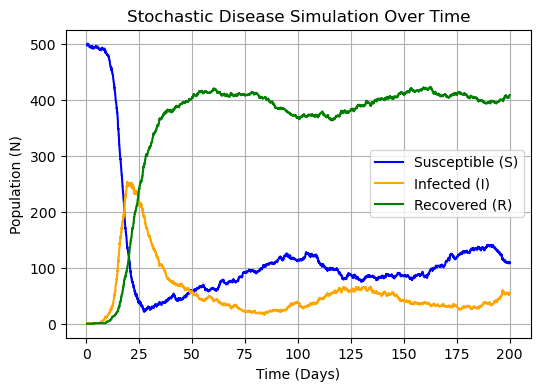

In [45]:
np.random.seed(49)

# Intitial population sizes
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

timespan = 200

run_gsp_simulation(sir, beta, gamma, mu, timespan)

## 2. Making a Deterministic SIR Model

A SIR model as created in the previous assignment is imported to analyze the difference between a deterministic and stochastic model. For clarity, all parameters are initiated again.

TO DO: How much do we need to explain this?


- Add similarity score between stochastic and derministic model.

In [46]:
def calc_ode(t, sir, parameters, N):
    """Calculates and returns the change in sir populations over 
    time.
    """
    
    beta, gamma, mu = parameters
    S, I, R = sir

    dSdt = (mu*N) - ((beta*S*I)/N) - (mu*S)
    dIdt = ((beta*S*I)/N) - (gamma*I) - (mu*I)
    dRdt = (gamma*I) - (mu*R)

    return [dSdt, dIdt, dRdt]


def run_sir_det(sir, parameters, N, t_span):
    """Runs the deterministic sir model with passed initial values.
    
    Arguments:
        sir: List of S, I, R and N populations.
        parameters: list containg recovery, infection and 
                    birth/death rate
        N: Total initial population
        t_span: Timespan in which the model is ran

    Returns: 
        Timespan used to model sir and population sizes of S, I and R.
    """

    time = np.linspace(0, t_span, 1000)
    sir_integration = solve_ivp(calc_ode, [time[0], time[-1]], sir, 
                                args=(parameters, N), t_eval=time)
    S, I, R = sir_integration.y

    return time, S, I, R


def plot_sir_det(time, S, I, R):
    """Plots the deterministic sir model."""

    plt.plot(time, S, label='Sus', color='b')
    plt.plot(time, I, label='Infected', color='orange')
    plt.plot(time, R, label='Rec', color='g')
    plt.xlabel('Time (days)')
    plt.ylabel('Population (N)')
    plt.legend()
    plt.title('Deterministic Disease Simulation over Time')
    plt.show()

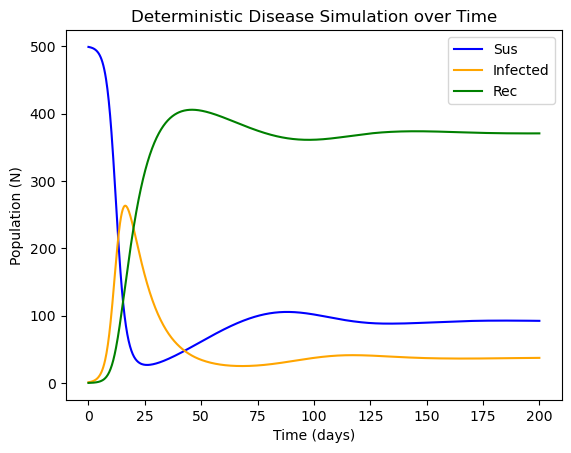

In [47]:
# Intitial population densities
N = 500
S0 = N - 1
I0 = N - S0
R0 = 0
sir_det = [S0, I0, R0]

# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.01
parameters = [beta, gamma, mu]

t_span = 200

# The semi-colon prevents the array from being printed in cell
time, S, I, R = run_sir_det(sir_det, parameters, N, t_span);
plot_sir_det(time, S, I, R)

## 3. Analyzing stochasticity

### 3.1 Comparing GSP with Deterministic
Both graphs of the deterministic and GSP model are overlapped with the same parameters to compare the difference between the results on a single run.

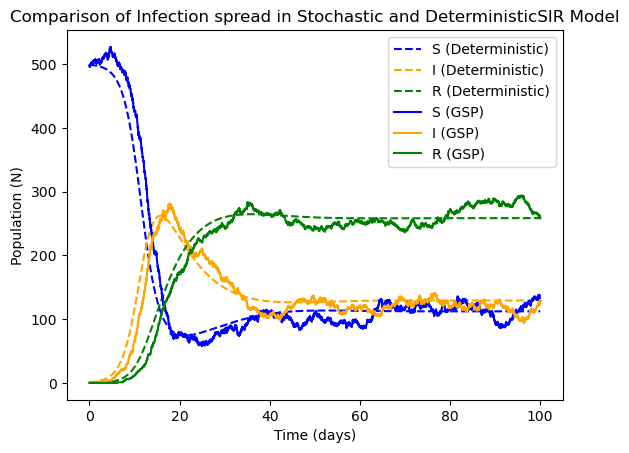

In [48]:
np.random.seed(33)

def plot_sir_detvsgsp(sir, parameters, t_span):
    """Plots the deterministic vs stochastic sir models."""

    S, I, R, N = sir
    sir_det = [S, I, R]
    beta, gamma, mu = parameters

    time, S_det, I_det, R_det = run_sir_det(sir_det, parameters, N, t_span)
    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)

    y_data = np.array(y_data)

    S_gsp = y_data[:, 0]
    I_gsp = y_data[:, 1]
    R_gsp = y_data[:, 2]

    plt.plot(time, S_det, label='S (Deterministic)', color='b', 
             linestyle='dashed')
    plt.plot(time, I_det, label='I (Deterministic)', color='orange', 
             linestyle='dashed')
    plt.plot(time, R_det, label='R (Deterministic)', color='g', 
             linestyle='dashed')

    plt.plot(t_events, S_gsp, label='S (GSP)', color='blue')
    plt.plot(t_events, I_gsp, label='I (GSP)', color='orange')
    plt.plot(t_events, R_gsp, label='R (GSP)', color='green')
    
    plt.xlabel('Time (days)')
    plt.ylabel('Population (N)')
    plt.legend()
    plt.title('Comparison of Infection spread in Stochastic and Deterministic' 
              'SIR Model')
    plt.show()


# Intitial population sizes
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

# Parameters for infection, recovery and death rate
beta = 0.6678
gamma = 0.1
mu = 0.05
parameters = [beta, gamma, mu]

t_span = 100

plot_sir_detvsgsp(sir, parameters, t_span)

### 3.2 Look at variance

The following cell runs gsp for different values of R0 as well as different population sizes N. We look at the between-run variance as well as the covariance between S and I while varying and and R0.

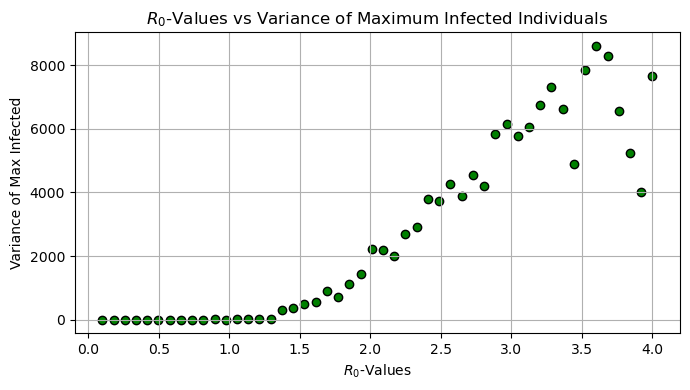

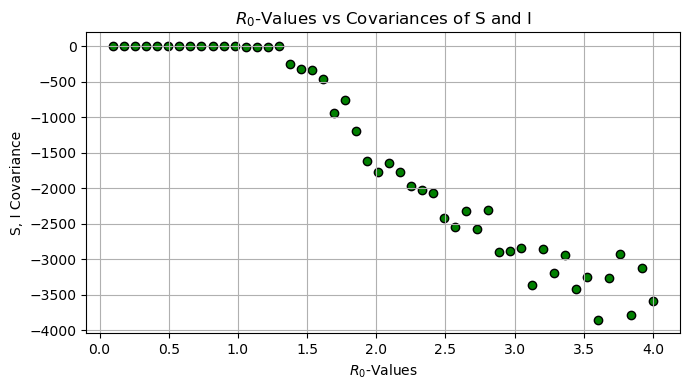

In [49]:
np.random.seed(35)


def generate_parameters(num_samples, R0_range=(0.1, 4.0), 
                        gamma_range=(0.1, 0.9)):
    """
    Generates beta-gamma pairs within specified ranges of R0 and gamma 
    values. Beta values are calculated based on the desired R0 values 
    and corresponding gamma values.

    Parameters:
        num_samples: Number of (beta, gamma) pairs to generate.
        R0_range: The range of R0 values (min, max).
        gamma_range: The range of gamma values to produce (min, max).

    Returns:
        List of beta-gamma pairs and an array of R0 values corresponding 
        to the pairs.
    """
    
    R0_vals = np.linspace(R0_range[0], R0_range[1], num_samples)
    gammas = np.linspace(gamma_range[0], gamma_range[1], num_samples)
    betas = R0_vals * gammas
    beta_gamma_pairs = list(zip(betas, gammas))

    return beta_gamma_pairs, R0_vals


def parameter_sweep(sir, pairs, mu, num_runs):
    """
    Runs multiple simulations on an SIR model by varying beta-gamma 
    parameters and calculates the variance of maximum infected 
    individuals and the covariance between S and I.

    Parameters:
        sir: The SIR model containing S, I and R populations.
        pairs: A list of beta-gamma pairs for the simulations.
        mu : Natural death rate.
        num_runs: Number of simulation iterations per beta-gamma pair.

    Returns:
        Variance of maximum infected valuesfor each beta-gamma pair and 
        covariance values between S and I for each beta-gamma pair.
    """
    
    variances = []
    covariances = []

    for beta, gamma in pairs:
        
        # For variance
        max_I_vals = []

        # For covariance
        S_vals= []
        I_vals = []
        
        # Run simulation n times for each (beta, gamma) pair.
        for _ in range(num_runs):
            result = gsp(sir, beta, gamma, mu, t_span)
            y_data = np.array(result[1])

            S = y_data[:, 0]
            I = y_data[:, 1]
            R = y_data[:, 2]

            S_vals.extend(S)
            I_vals.extend(I)

            max_I_vals.append(np.max(I))

        # Variance for each (beta, gamma) pair after n runs is recorded.
        variances.append(np.var(max_I_vals))
        covariance_matrix = np.cov(S_vals, I_vals)
        covariances.append(covariance_matrix[0, 1])

    return variances, covariances


def plot_R0_vs_variance(R0_vals, variances):
    """
    Plots the relationship between R0 values and variance in the maximum 
    number of infected individuals for different parameter pairs.

    Parameters:
        R0_vals: List of R0 values corresponding to the parameter pairs.
        variances: Variances of the maximum infected individuals for 
        each R0 value.

    Returns:
        None. Displays a scatter plot.
    """

    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, variances, color='green', edgecolor='black')

    plt.xlabel(r'$R_0$-Values')
    plt.ylabel('Variance of Max Infected')
    plt.title(r'$R_0$-Values vs Variance of Maximum Infected Individuals')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("R0vsvar.png", dpi=150)
    plt.show()


def plot_R0_vs_covariances(R0_vals, covariances):
    """
    Plots the relationship between R0 values and the covariance between 
    susceptible and infected individuals for different parameter pairs.

    Parameters:
        R0_vals: List of R0 values corresponding to the parameter pairs.
        covariances: Covariance values between S and I for each R0 value.

    Returns:
        None. Displays a scatter plot.
    """

    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, covariances, color='green', edgecolor='black')
    
    plt.xlabel(r'$R_0$-Values')
    plt.ylabel('S, I Covariance')
    plt.title(r'$R_0$-Values vs Covariances of S and I')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("R0vscovar.png", dpi=150)
    plt.show()


num_pairs = 50
num_runs = 20

sample_pairs, sample_R0_vals = generate_parameters(num_pairs)
variances, covariances = parameter_sweep(sir, sample_pairs, mu, num_runs)

# Combine and sort by R0 for variance analysis.
var_combined = list(zip(sample_R0_vals, variances))
sorted_var_combined = sorted(var_combined)
sorted_R0_vals, sorted_variances = zip(*sorted_var_combined)

# Combine and sort by R0 for covariance analysis.
covar_combined = list(zip(sample_R0_vals, covariances))
sorted_covar_combined = sorted(covar_combined)
sorted_R0_vals, sorted_covariances = zip(*sorted_covar_combined)

plot_R0_vs_variance(sorted_R0_vals, sorted_variances)
plot_R0_vs_covariances(sorted_R0_vals, sorted_covariances)

### 3.3 Calculate the Mean

Since a stochastic simulation may render more extremes, we wanted to calculate and visualizes a mean for the stochastic SIR model to compare with the deterministic model. 

However, every gsp run may result in different time steps. Therefore we had to initialize dictionaries to store variables for each run at fixed steps. These steps were chosen by starting at t = 0 and ending at t = timespan. Here the timespan equals the timespan used for the gsp function. Steps were taken with equal spacing.

For every gsp mean, the values of S, I and R (and N) at these specific time steps was saved. This was done by iterating over the list of fixed_steps and finding the S, I, R and N values at that point in time. The corresponding values are then stored in a dictionary with fixed_steps. This will eventually result in a dictionary with fixed time steps and values for S, I, R and N at each of those fixed steps. The amount of values at each step depends on how often the stochastic sir simulation was performed.

The mean and std of each time step is then calculated and stored in seperate dictionaries.


Since the steps at which S, I and R are recorded in the mean may differ from the fixed_steps that we determined, the lowest closest value was chosen and the S, I and R values were placed to the right of that value on the timeline

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


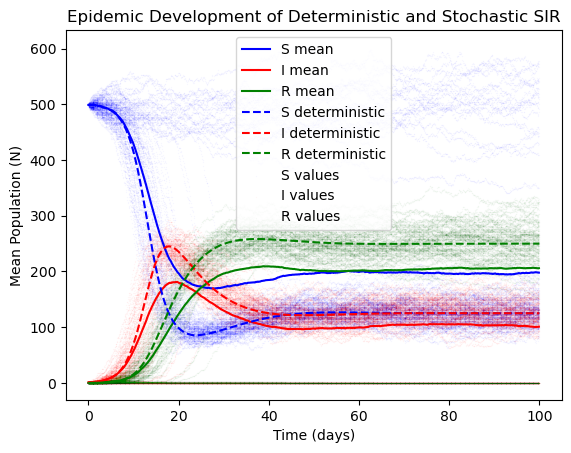

In [50]:
np.random.seed(29)

def gsp_mean(runs, t_span, sir, parameters):
    """
    This function runs the gsp SIR model a set number of times to 
    calculate the mean and standard deviation the runs.

    Arguments:
        runs: Number of times to run the gsp function
        t_span: Lower bound for the ratio of R0 values.
        sir: List of S, I, R and N populations.
        parameters: list containg recovery, infection and 
                    birth/death rate
    
    Returns:
        Dictionaries with information stored of the results, mean and 
        standard deviation of each time step. Also returns a list of 
        maximum I values for each run.
    """

    beta, gamma, mu = parameters 
    t_steps = t_span/ 1000

    fixed_steps = np.round(np.arange(0, t_span, t_steps), 2)

    # Store data from a run at fixed time steps.
    results = {
        'time': fixed_steps.tolist(),
        'S': {round(step, 4): [] for step in fixed_steps},
        'I': {round(step, 4): [] for step in fixed_steps},
        'R': {round(step, 4): [] for step in fixed_steps},
        'N': {round(step, 4): [] for step in fixed_steps}
        }
    
    results_mean = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }
    
    results_stdev = {
        'S': [],
        'I': [],
        'R': [],
        'N': []
        }

    peak_infected = []

    I_max = 0
    t_max = 0

    for _ in range(runs):
        t_events , y_data = gsp(sir, beta, gamma, mu, t_span)

        I_max = 0
        t_max = 0

        # Finds closest lower value of foxed_steps in t_events.
        for steps in fixed_steps:
            steps = round(steps, 4)

            position_value = bisect.bisect_right(t_events, steps)

            if position_value > 0:
                position_value -= 1

            S, I, R = y_data[position_value]

            if I > I_max:
                I_max = I
                t_max = t_events[position_value]

            results['S'][steps].append(S)
            results['I'][steps].append(I)
            results['R'][steps].append(R)
            results['N'][steps].append(S + I + R)
            
        peak_infected.append([t_max, I_max])

    for steps in fixed_steps:
        results_mean['S'].append(np.mean(results['S'][steps]))
        results_mean['I'].append(np.mean(results['I'][steps]))
        results_mean['R'].append(np.mean(results['R'][steps]))
        results_mean['N'].append(np.mean(results['N'][steps]))

        results_stdev['S'].append(np.std(results['S'][steps]))
        results_stdev['I'].append(np.std(results['I'][steps]))
        results_stdev['R'].append(np.std(results['R'][steps]))
        results_stdev['N'].append(np.std(results['N'][steps]))
    
    return results, results_mean, results_stdev, peak_infected


def plot_mean(results, results_mean, sir):
    """
    Visualizes the results from the gsp_mean function as changes in 
    population sizes over time.
    """
   
    S, I, R, N = sir
    sir_det = [S, I, R]

    S_mean = results_mean['S']
    I_mean = results_mean['I']
    R_mean = results_mean['R']
    time = results['time']

    time_2, S, I, R = run_sir_det(sir_det, parameters, N, t_span)
    
    plt.plot(time, S_mean, label='S mean', color='blue')
    plt.plot(time, I_mean, label='I mean', color='red')
    plt.plot(time, R_mean, label='R mean', color='green')
    plt.plot(time_2, S, label='S deterministic', color='blue', 
             linestyle='dashed')
    plt.plot(time_2, I, label='I deterministic', color='red', 
             linestyle='dashed')
    plt.plot(time_2, R, label='R deterministic', color='green', 
             linestyle='dashed')

    time_steps_S = []
    time_steps_I = []
    time_steps_R = []
    S_values = []
    I_values = []
    R_values = []

    for time_step, values in results['S'].items():
        for value in values:
            time_steps_S.append(time_step)
            S_values.append(value)
    
    for time_step, values in results['I'].items():
        for value in values:
            time_steps_I.append(time_step)
            I_values.append(value)

    for time_step, values in results['R'].items():
        for value in values:
            time_steps_R.append(time_step)
            R_values.append(value)

    plt.scatter(time_steps_S, S_values, alpha=0.03, linewidths=0, 
                color='blue', marker='o', label='S values', s=1)
    plt.scatter(time_steps_I, I_values, alpha=0.03, linewidths=0, 
                color='red', marker='o', label='I values', s=1)
    plt.scatter(time_steps_R, R_values, alpha=0.03, linewidths=0, 
                color='green', marker='o', label='R values', s=1)

    plt.xlabel('Time (days)')
    plt.ylabel('Mean Population (N)')
    plt.legend()
    plt.title('Epidemic Development of Deterministic and Stochastic SIR')
    plt.show()

    return


# Intitial population sizes
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.1
mu = 0.05
parameters = [beta, gamma, mu]

t_span = 100
runs = 100

results, results_mean, results_stdev, _ = gsp_mean(runs, t_span, sir, 
                                                   parameters);
plot_mean(results, results_mean, sir)

Additional plots for the mean was run to understand the effect of decreasing the R0 and increasinmg N.

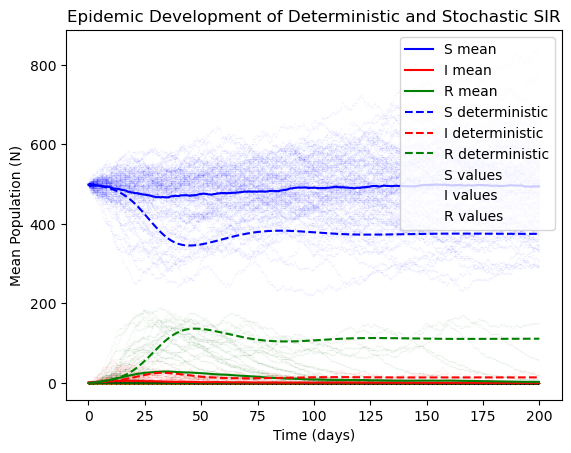

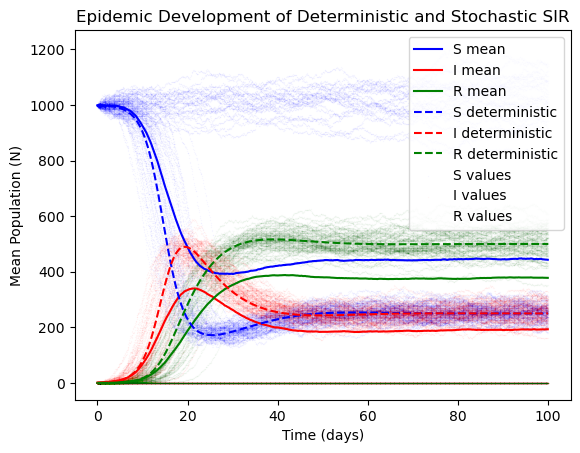

In [55]:
# Intitial population sizes
N = 500
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

# Parameters for infection, recovery and death rate
beta = 0.6
gamma = 0.4
mu = 0.05
parameters = [beta, gamma, mu]

t_span = 200
runs = 100

results, results_mean, results_stdev, _ = gsp_mean(runs, t_span, sir, 
                                                   parameters);
plot_mean(results, results_mean, sir)


N = 1000
S = N - 1
I = N - S
R = 0
sir = [S, I, R, N]

beta = 0.6
gamma = 0.1
mu = 0.05
parameters = [beta, gamma, mu]

t_span = 100
runs = 100

results, results_mean, results_stdev, _ = gsp_mean(runs, t_span, sir, 
                                                   parameters);
plot_mean(results, results_mean, sir)


### 3.4 R0 vs Extinction Events

The following cell computes the number of extinctions for varying R0 values.

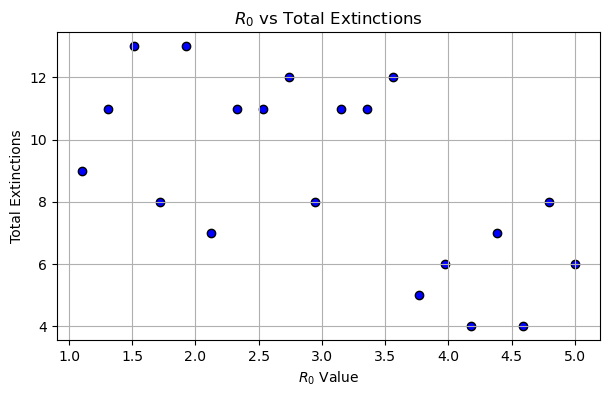

In [57]:
np.random.seed(20)

def generate_large_R0(num_samples, R0_range=(1.1, 5), gamma_value=0.1):
    """
    Generates beta and gamma pairs such that the R0 values range 
    from 1.1 to 5.
    
    Arguments:
        num_samples: Number of beta/gamma pairs to generate.
        R0_range: Range for R0 values.
        gamma_value: Fixed value for gamma.
    
    Returns:
        Lists of beta gamma pairs and R0 values.
    """
    
    R0_vals = np.linspace(R0_range[0], R0_range[1], num_samples)
    
    # Use a fixed gamma value, and calculate corresponding beta = R0 * gamma
    gammas = np.full(num_samples, gamma_value)
    betas = R0_vals*gammas 
    beta_gamma_pairs = list(zip(betas, gammas))
    
    return beta_gamma_pairs, R0_vals


def count_R0_extinctions(pairs, num_runs):
    """
    Counts the number of epidemic extinctions for each R0 pair for 
    multiple simulation runs. Extinctions are valid when below a 
    specified threshold.

    Arguments:
        pairs: List containing beta and gamma values for each R0.
        num_runs: Number of simulation runs for each (beta, gamma) pair.

    Returns:
        A list containing the number of observed extinctions for each 
        (beta, gamma) pair.
    """

    extinction_list = []

    for beta, gamma in pairs:
        num_extinctions = 0
    
        for _ in range(num_runs):
                result = gsp(sir, beta, gamma, mu, t_span)
                y_data = np.array(result[1])

                I = y_data[:, 1]

                mean = np.mean(I)

                if mean < 1e-2:
                    num_extinctions += 1

        extinction_list.append(num_extinctions)

    return extinction_list
        

def plot_results_R0(num_pairs, num_runs):
    """
    Generates a plot for the average number of extinctions across a 
    range of R0 values.

    Arguments:
        num_pairs: Number of (beta, gamma) pairs to generate.
        num_runs: Number of simulation runs to make for each pair.

    Returns:
        None. Displays a bar plot.
    """
    
    # Generate parameters and count extinctions
    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)
    R0_extinctions = count_R0_extinctions(sample_pairs, num_runs)

    # Sort R0 values and corresponding extinctions
    R0_extinction_pairs = list(zip(sample_R0_vals, R0_extinctions))
    sorted_R0_extinction_pairs = sorted(R0_extinction_pairs)

    sorted_R0_vals, sorted_extinctions = zip(*sorted_R0_extinction_pairs)

    plt.figure(figsize=(7, 4))
    plt.scatter(sorted_R0_vals, sorted_extinctions, color='blue', 
                edgecolor='black')
    plt.xlabel(r"$R_0$ Value")
    plt.ylabel("Total Extinctions")
    plt.title(r"$R_0$ vs Total Extinctions")
    plt.grid(True)
    plt.savefig('R0vsext.png', dpi=150)
    plt.show()


num_pairs = 20
num_runs = 50
mu = 0.0001

plot_results_R0(num_pairs, num_runs)

### 3.5 N vs Extinction Events

Similar to the cell above. We again count the number of extinctions. This time, however, we vary N.
Please note: Runtime is about 5 minutes.

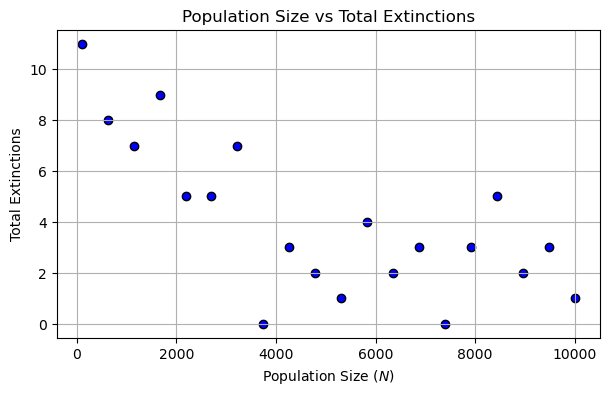

In [58]:
np.random.seed(44)


def generate_populations(num_pops):
    """Generate evenly space populations."""

    populations = []
    
    # Evenly distributes populations from 100 to 10,000.
    S_0 = np.linspace(100, 10000, num_pops)

    for i in range(num_pops):
        S = S_0[i]
        I = 1
        R = 0
        N = S + I
        sir = (S, I, R, N)
        populations.append(sir)
    
    return populations


def count_N_extinctions(num_pops, num_runs):
    """Count the number of extinctions per population"""

    populations = generate_populations(num_pops)
    extinction_list = []

    for pop in populations:
        num_extinctions = 0
        for _ in range(num_runs):
            result = gsp(pop, beta, gamma, mu, t_span)
            y_data = np.array(result[1])
            I = y_data[:, 1]
            mean = np.mean(I)

            # Treats any value below a small threshold as extinction.
            if mean < 1e-3:
                num_extinctions += 1
        
        extinction_list.append(num_extinctions)
    
    return extinction_list


def plot_results_N(num_pops, num_runs):
    """Plot results as scatter plot of total extinctions per population
    size.
    """
    
    sample_pops = generate_populations(num_pops)
    N_extinctions = count_N_extinctions(num_pops, num_runs)

    # Extract population sizes (N) and extinction counts
    population_sizes = [pop[3] for pop in sample_pops] 

    plt.figure(figsize=(7, 4))
    plt.scatter(population_sizes, N_extinctions, color='blue', 
                edgecolor='black')
    plt.xlabel(r"Population Size ($N$)")
    plt.ylabel("Total Extinctions")
    plt.title("Population Size vs Total Extinctions")
    plt.grid(True)
    plt.savefig("Nvsext.png", dpi=150)
    plt.show()


# Parameters
beta = 0.4
gamma = 0.1
mu = 0.0001
num_pops = 20
num_runs = 50

plot_results_N(num_pops, num_runs)

### 3.6 Extinctions as a Function of R0 and N

Here, we look at how both N and R0 interact, leading to different rates of extinction. Please note that running this plot may require large amounts of time.

In [59]:
def plot_results_R0_N(num_pairs, num_pops, num_runs):
    """Plot a 3D surface plot of extinction counts across R0 values and 
    population sizes."""

    sample_pairs, sample_R0_vals = generate_large_R0(num_pairs)
    populations = generate_populations(num_pops)

    extinction_data = []

    for (beta, gamma), R0 in zip(sample_pairs, sample_R0_vals):
        for pop in populations:
            num_extinctions = 0

            for _ in range(num_runs):
                result = gsp(pop, beta, gamma, mu, t_span)
                y_data = np.array(result[1])
                I = y_data[:, 1]
                mean = np.mean(I)

                if mean < 1e-2:
                    num_extinctions += 1

            N = pop[3]  
            extinction_data.append((N, R0, num_extinctions))

    extinction_data = np.array(extinction_data)

    N_values = extinction_data[:, 0]
    R0_values = extinction_data[:, 1]
    extinction_counts = extinction_data[:, 2]

    # Create a grid for N and R0 values
    N_grid, R0_grid = np.meshgrid(
        np.linspace(N_values.min(), N_values.max(), 100),
        np.linspace(R0_values.min(), R0_values.max(), 100)
    )

    # Interpolate extinction counts for the surface plot
    extinction_grid = griddata(
        (N_values, R0_values), extinction_counts, (N_grid, R0_grid), 
        method='cubic'
        )

    # 3D Surface Plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(N_grid, R0_grid, extinction_grid, cmap='plasma', 
                              edgecolor='none')

    ax.set_xlabel('Population Size ($N$)')
    ax.set_ylabel(r"$R_0$ Value")
    ax.set_zlabel('Total Extinctions')
    ax.set_title(r"Extinction Counts across Population Size and $R_0$")

    cbar = plt.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Number of Extinctions')

    plt.savefig('/content/drive/MyDrive/NvsR0vsext_surface.png', dpi=150)
    plt.show()

num_pairs = 20
num_pops = 20
num_runs = 20
mu = 0.0001

plot_results_R0_N(num_pairs, num_pops, num_runs)

KeyboardInterrupt: 

### 3.7 Stochastic Resonance
By visualizing the stochastic SIR model and deterministic models together, we may note how the stochastic model fluctuates around the deterministic model. To take a closer look at this relation between the two, we plot the two against each other for different values of R indicating an epidemic and endemic situation (R = 3, R = 1, R = 0.5)

Since the stochastic value may generate different values ech run, we plot multiple stochastic graphs to one deterministic to also understand how they differ. 

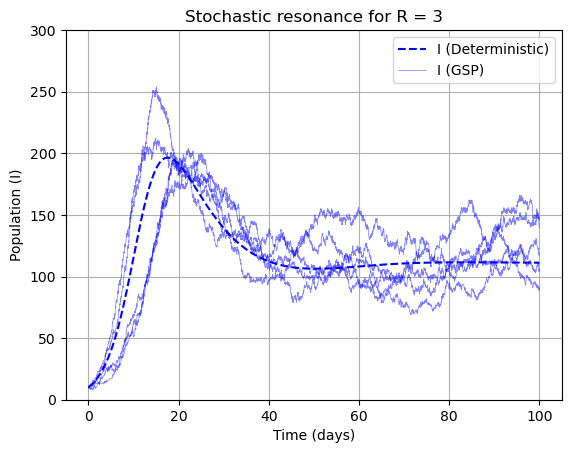

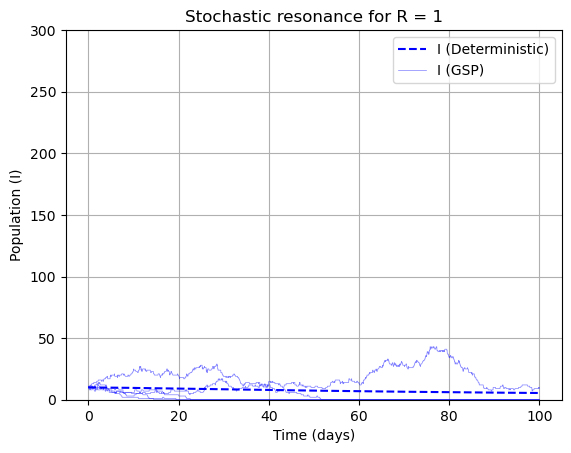

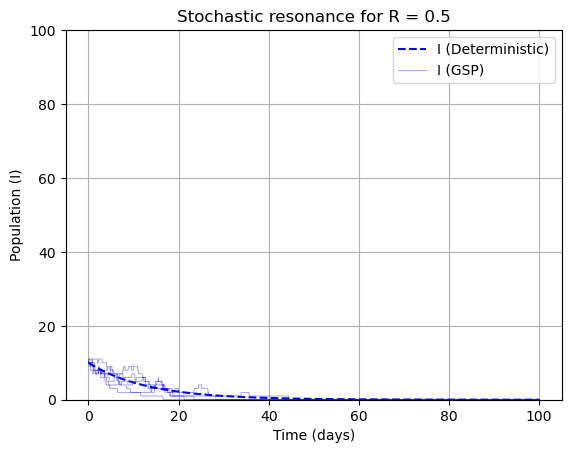

In [60]:
np.random.seed(33)


def plot_sir_stoc(sir, parameters, t_span, R0):
    """Plots the deterministic vs stochastic sir models to visualize 
    stocastic resonance.
    """

    S, I, R, N = sir
    sir_det = [S, I, R]
    beta, gamma, mu = parameters

    # Retrieves and plots the deterministic model.
    time, _, I_det, _ = run_sir_det(sir_det, parameters, N, t_span)
    plt.plot(time, I_det, label='I (Deterministic)', color='blue', 
             linestyle='dashed')

    # Retrieves and plots the stochastic model 5 times.
    for index in range(5):
        t_events, y_data = gsp(sir, beta, gamma, mu, t_span)
        y_data = np.array(y_data)

        I_gsp = y_data[:, 1]

        if index == 0:
            plt.plot(t_events, I_gsp, alpha=0.5, label='I (GSP)', color='blue', 
                     linewidth=0.5)
        else:
            plt.plot(t_events, I_gsp, alpha=0.5, color='blue', linewidth=0.5)
    
    if R0 < 1:
        plt.ylim(0, 100)
    else:
        plt.ylim(0, 300)

    plt.xlabel('Time (days)')
    plt.ylabel('Population (I)')
    plt.legend()
    plt.grid(True)
    plt.title(f'Stochastic resonance for R = {R0}')
    plt.show()


# Intitial population sizes
N = 500
S = N - 10
I = N - S
R = 0
sir = [S, I, R, N]

t_span = 100
gamma = 0.1
mu = 0.05

# Plot stochastic resenance for R0 = 3.
R0 = 3
beta = R0 * (gamma + mu)
parameters = [beta, gamma, mu]
plot_sir_stoc(sir, parameters, t_span, R0)

# Plot stochastic resenance for R0 = 1.
R0 = 1
beta = R0 * (gamma + mu)
parameters = [beta, gamma, mu]
plot_sir_stoc(sir, parameters, t_span, R0)

# Plot stochastic resenance for R0 = 0.5.
R0 = 0.5
beta = R0 * (gamma + mu)
parameters = [beta, gamma, mu]
plot_sir_stoc(sir, parameters, t_span, R0)

# SIR in Network Models

## 1. Barabasi Albert Network 
A Barabasi-Albert (BA) network is a scale-free network.This network aaplies a prefferential attachment method meaning that nodes who are more connected are more likely to aquire new edges. New nodes are therefore more likely to connect to existing nodes with a higher degree of connection.

For clarification: The '0' status is equivalent to 'susceptible', '1' is equivalent to 'infected' and '2' means 'removed'.

### 1.1 Barabasi Albert Network
With the help of the NetworkX library a random graph using the BA method of attaching nodes is created. By supplying the graph to the Network Diffusion Library (NDlib), a SIR model is created through setting up the appropriate parameters through functions supplied by the Configuration class of NDLib. The model is iterated t_span amount of times, after which the appropriate data is returned. To create a BA network, we supply a variable m which indicates the number of edges to attach from a new node to an existing node. 

In [61]:
def barabasi_albert(N, m, beta, gamma, I0, t_span):
    """
    This function generates a Barabasi-Albert (scale-free) network model. 

    Arguments:
        N: Total number of nodes.
        m: Number of edges to attach from new node to existing node. 
        beta: Infection rate.
        gamma: Recovery rate.
        I0: Initial number of infected nodes.
        t_span: Number of iterations to execute the model.

    Returns:
        Lists for the number of iterations generated by the model and 
        data concerning the S, I and R populations of each iteration.
    """

    ba_graph = nx.barabasi_albert_graph(N, m)
    model = ep.SIRModel(ba_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)  
    config.add_model_parameter('gamma', gamma)  
    config.add_model_parameter("fraction_infected", I0)  

    model.set_initial_status(config)
    iterations = model.iteration_bunch(t_span)
    
    y_data = []  

    for iteration in iterations:
        status = iteration['status']
        
        S_count = 0
        I_count = 0
        R_count = 0
        
        for _, state in status.items():
            if state == 0:  
                S_count += 1
            elif state == 1:  
                I_count += 1
            elif state == 2:  
                R_count += 1
        
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data  

### 1.2 Barabasi Albert Network Parameter Sweep
In order to understand the effect of supplying different values for m, a parameter sweep is performed by generating a list of values for m. Additionally, we also want to compare this with changing values for the basic reproductive number (R0). List for these parameters are supplied to a function that will iterate over the lists in seperate functions and run the Barabasi-Albert (BA) network for each value set a specified of times. Data from the BA network is returned and lists of the maximum mean and standard deviations of the number of infected nodes is generated. These values can then be supplied to another function to plot the result and visualize the effect of changing these parameters. 

In [62]:
def ba_m_sweep(N, m_values, beta, gamma, I0, t_span, num_runs):
    """
    Generates a Barabasi-Albert (BA) network for different values of m 
    and finds the mean maximum and standard deviation of the number of 
    infected nodes per run.

    Arguments:
        N: Total number of nodes
        m_values: List of m values.
        beta: Infection rate.
        gamma: Recovery rate.
        I0: Percentage of initially infected nodes.
        t_span: Number of iterations inside BA network.
        num_runs: Number of iterations of BA network.

    Returns:
        A list of maximum mean and standard deviations of the number of 
        infected nodes per run.
    """

    mean_max_values = []
    std_max_values = []

    # Iterate over all values for m to generate a BA network.
    for m in m_values:
        max_I_values = []
        
        for _ in range(num_runs):  
            _, y_data = barabasi_albert(N, m, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values


def plot_ba_m_sweep(N, m_values, beta_values, gamma_values, I0, t_span, 
                    num_runs):
    """Visualizes data for the parameter sweeps of the BA network."""

    plt.figure(figsize=(7, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        mean_max_values, std_max_values = ba_m_sweep(N, m_values, beta, gamma, 
                                                     I0, t_span, num_runs)
        R0 = beta/gamma

        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(m_values, mean_max_values, yerr=std_max_values, fmt='-o', 
                     capsize=5, label=label)
    
    plt.xlabel(r"Number of edges ($m$)") 
    plt.ylabel(r"Mean Maximum Infected Nodes ($I$)")
    plt.title("Mean Maximum Infected Nodes vs Number of Edges" 
              " for Different R₀ Values")
    plt.legend(loc="best", fontsize="small")  
    plt.grid(True)
    plt.savefig("BA-sweep.png")
    plt.show()


def ba_m_vs_R0(N, m_values, I0, t_span, num_runs, R0_values, gamma_values):
    """This function generates a list for combinations of beta and gamma 
    values based on a supplied list of gamma and R0 values.
    """

    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    
    plot_ba_m_sweep(N, m_values, beta_values, gamma_values, I0, t_span, 
                    num_runs)

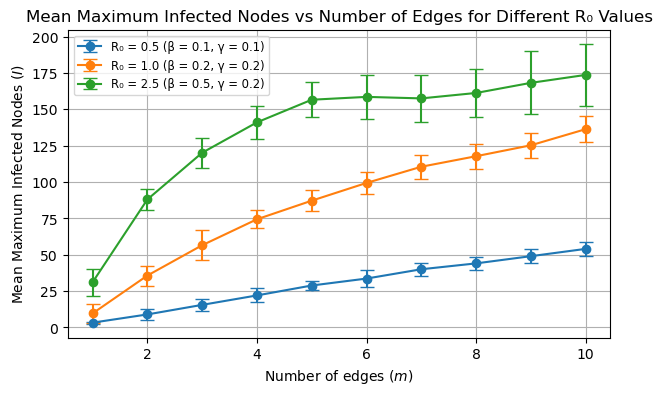

In [63]:
N = 300
m_values = np.arange(1, 11, 1)
R0_values = [0.5, 1.0, 2.5] 
gamma_values = [0.1, 0.2, 0.2]
I0 = 0.01
t_span = 50
num_runs = 50

ba_m_vs_R0(N, m_values, I0, t_span, num_runs, R0_values, gamma_values)

## 2. Watts-Strogatz
In a Watts-Strogatz network model a random graph of small-world properties is generated. The model interpolates between a randomized structure and ring lattice by generating a ring lattice with N nodes and connecting each node with k number of it's nearest neighbors on either side of the node. Nodes are rewired with a probability p. This typically generates short path lengths and high clustering.

### 2.1 Watts-Strogatz Network
To create the model a graph of a WS network is created with the NetworkX library by supplying WS specific parameters k and p. The graph is passed to NDLib to create a SIR Model. A configuration class is initialized to which parameters are given to build the SIR model through built-in class functions. The SIR model is generated by iterating over it a set number of times and changing the SIR populations accordingly. The data of each S, I and R population is gathered along the appropriate time steps and returned. Creation of the WS graph is specifically dependent on parameters k (Number of nearest neighbors to connect a node in ring topology) and p (Rewiring probability of each edge) and the number of nodes which are all supplied to the graph. 

In [64]:
def watts_strogatz(N, k, p, beta, gamma, I0, t_span):
    """
    Generates a Watts-Strogatz (WA) network model graph and gathers data on S, 
    I and R populations.

    Arguments:
        N: number of nodes.
        k: Number of nearest neighbors to connect a node in ring topology.
        p: Rewiring probability of each edge.
        beta: Infection rate.
        gamma: Recovery rate.
        I0: Initial percentage of infected nodes.
        t_span: Number of iterations to execute the model.

    Returns: 
        Lists for the number of iterations generated by the model and 
        data concerning the S, I and R populations of each iteration.
    """

    ws_graph = nx.watts_strogatz_graph(N, k, p)
    model = ep.SIRModel(ws_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", I0)
    model.set_initial_status(config)

    iterations = model.iteration_bunch(t_span)
    
    y_data = []

    for iteration in iterations:
        status = iteration['status']
        
        S_count = 0
        I_count = 0
        R_count = 0
        
        for _, state in status.items():
            if state == 0:
                S_count += 1
            elif state == 1:
                I_count += 1
            elif state == 2:
                R_count += 1
        
        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data

In [65]:
N = 1000
k = 6    # Number of neighbors to rewire
p = 0.1    # Rewiring probability
t_span = 200

results = watts_strogatz(N, k, p, beta, gamma, I0, t_span)
print(results)

([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 1, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 1, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 1, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 

### 2.2 Watts-Strogatz Network parameter Sweep 
As with the BA network, a parameter sweep for network specific parameters was performed. Parameters were changed for k and R0. The sweeps were set up similarly to the BA network sweep with the only changes being instead of m, k is varied. R0 are varied for both. Again, lists of the maximum mean and standard deviations of the number of infected nodes is generated and can subsequently be plotted.

In [66]:
def ws_k_sweep(N, r_vals, k, beta, gamma, I0, t_span, num_runs):
    """
    Generates a WS network for different values of k and finds the mean 
    maximum and standard deviation of the number of infected nodes per 
    run.

    Arguments:
        N: Total number of nodes
        k: Number of neighbors to connect to.
        r_values: Range of rewiring probabilities.
        beta: Infection rate.
        gamma: Recovery rate.
        I0: Percentage of initially infected nodes.
        t_span: Number of iterations inside BA network.
        num_runs: Number of iterations of BA network.

    Returns:
        A list of maximum mean and standard deviations of the number of 
        infected nodes per run.
    """

    mean_max_values = []
    std_max_values = []

    for r in r_vals:
        max_I_values = []
        
        for _ in range(num_runs):  
            _, y_data = watts_strogatz(N, k, r, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            # Get the maximum infected value in the current run
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values


#Finished
def plot_ws_k_sweep(N, r_vals, k, beta_values, gamma_values, I0, t_span, 
                    num_runs):
    """"Visualizes data for the parameter sweeps of the WS network."""""

    plt.figure(figsize=(7, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        
        mean_max_values, std_max_values = ws_k_sweep(N, r_vals, k, beta, gamma, 
                                                     I0, t_span, num_runs)
        
        R0 = beta/gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        plt.errorbar(r_vals, mean_max_values, yerr=std_max_values, fmt='-o', 
                     capsize=5, label=label)
    
    plt.xlabel(r"Rewiring Probability ($p_r$)") 
    plt.ylabel(r"Mean Maximum Infected Nodes $I$")
    plt.title("Mean Maximum Infected Nodes vs Number of Neighbors for "
              "Different R₀ Values"
              )
    plt.legend(loc="best", fontsize="small")
    plt.ylim(0, 160)  
    plt.grid(True)
    plt.savefig("WS-sweep.png")
    plt.show()

# Finished
def ws_r_vs_R0(N, r_vals, k, I0, t_span, num_runs, R0_values, gamma_values):
    """This function generates a list for combinations of beta and gamma 
    values based on a supplied list of gamma and R0 values.
    """

    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    plot_ws_k_sweep(N, r_vals, k, beta_values, gamma_values, I0, t_span, 
                    num_runs)

    return

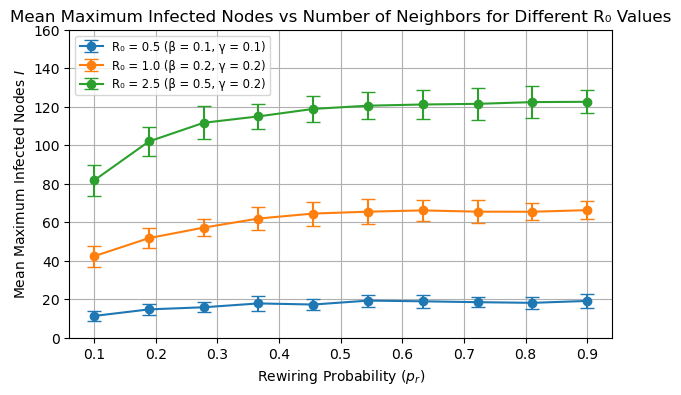

In [67]:

N = 300
R0_values = [0.5, 1.0, 2.5] 
gamma_values = [0.1, 0.2, 0.2]
r_vals = np.linspace(0.1, 0.9, 10)
k = 8
I0 = 0.01
t_span = 50
num_runs = 50

ws_r_vs_R0(N, r_vals, k, I0, t_span, num_runs, R0_values, gamma_values)

## 3. Erdos-Renyi
The specified library NetworkX uses an Erdos-Renyi network model G(n,p) that generates a random graph by connecting nodes with edges. According to a parameter p, each specific edge is included into the graph. A higher p means a higher number of edges.

### 3.1 Erdos-Renyi Network
With the help of the NetworkX library a random graph using the ER G(n,p) method of attaching nodes is created. By supplying the graph to the Network Diffusion Library (NDlib), a SIR model is created through setting up the appropriate parameters through functions supplied by the Configuration class of NDLib. The model is iterated t_span amount of times, after which the appropriate data is returned. To create a ER network, we supply the variable p.

In [68]:
def erdos_renyi(N, p, beta, gamma, I0, t_span):
    """ 
    This function generates a ER network model. 

    Arguments:
        N: Total number of nodes.
        p: Probability for edge creation 
        beta: Infection rate.
        gamma: Recovery rate.
        I0: Initial number of infected nodes.
        t_span: Number of iterations to execute the model.

    Returns:
        Lists for the number of iterations generated by the model and 
        data concerning the S, I and R populations of each iteration.
    """
    
    er_graph = nx.erdos_renyi_graph(N, p)
    model = ep.SIRModel(er_graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", I0)
    model.set_initial_status(config)

    iterations = model.iteration_bunch(t_span)

    y_data = [] 

    for iteration in iterations:
        status = iteration['status']
        
        S_count = 0
        I_count = 0
        R_count = 0
        
        for _, state in status.items():
            if state == 0:
                S_count += 1
            elif state == 1:
                I_count += 1
            elif state == 2: 
                R_count += 1

        y_data.append({'S': S_count, 'I': I_count, 'R': R_count})

    return iterations, y_data

In [69]:
N = 300
p = 0.01  # Probability for edge creation
t_span = 50

results = erdos_renyi(N, p, beta, gamma, I0, t_span)
print(results)

([{'iteration': 0, 'status': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 1, 

### 3.2 Erdos-Reyni Network Parameter Sweep
As with the BA and WS networks, a parameter sweep for network specific parameters was performed. Parameters were changed for p and R0. The sweeps were set up similarly to the other network sweeps. Again, lists of the maximum mean and standard deviations of the number of infected nodes is generated and can subsequently be plotted.

In [70]:
def er_p_sweep(N, p_values, beta, gamma, I0, t_span, num_runs):
    """
    Generates a ER network for different values of p and finds the mean 
    maximum and standard deviation of the number of infected nodes per 
    run.

    Arguments:
        N: Total number of nodes
        p_values: List of p values.
        beta: Infection rate.
        gamma: Recovery rate.
        I0: Percentage of initially infected nodes.
        t_span: Number of iterations inside BA network.
        num_runs: Number of iterations of BA network.

    Returns:
        A list of maximum mean and standard deviations of the number of 
        infected nodes per run.
    """

    mean_max_values = []  
    std_max_values = []   

    for p in p_values:
        max_I_values = []  
        
        for _ in range(num_runs):  
            _, y_data = erdos_renyi(N, p, beta, gamma, I0, t_span)
            
            I_values = [data['I'] for data in y_data]
            
            max_I = max(I_values) if I_values else 0
            max_I_values.append(max_I)
        
        mean_max_I = np.mean(max_I_values) if max_I_values else 0
        std_max_I = np.std(max_I_values) if max_I_values else 0
        
     
        mean_max_values.append(mean_max_I)
        std_max_values.append(std_max_I)
    
    return mean_max_values, std_max_values  


def plot_er_prob_sweep(N, p_values, beta_values, gamma_values, I0, t_span, 
                       num_runs):
    """"Visualizes data for the parameter sweeps of the ER network."""""

    plt.figure(figsize=(7, 4))
    
    for beta, gamma in zip(beta_values, gamma_values):
        # Calculate mean and standard deviation for each beta and gamma pair.
        mean_max_values, std_max_values = er_p_sweep(N, p_values, beta, gamma, 
                                                     I0, t_span, num_runs)
        
        # Calculate R0 and create label.
        R0 = beta / gamma
        label = f'R₀ = {R0:.1f} (β = {beta:.1f}, γ = {gamma:.1f})'
        
        # Plot error bars for each beta and gamma pair.
        plt.errorbar(p_values, mean_max_values, yerr=std_max_values, fmt='-o', 
                     capsize=5, label=label)
    
    plt.xlabel(r"Probability of connecting two nodes ($p$)") 
    plt.ylabel(r"Mean Maximum Infected Nodes ($I$)")
    plt.title("Mean Maximum Infected Nodes vs Probability for Different R₀ "
              "Values")
    plt.legend(loc="best", fontsize="small")  
    plt.grid(True)
    plt.savefig("ER-sweep.png")
    plt.show()


def er_prob_vs_R0(N, p_values, I0, t_span, num_runs, R0_values, gamma_values):
    """This function generates a list for combinations of beta and gamma 
    values based on a supplied list of gamma and R0 values.
    """

    beta_values = [R0 * gamma for R0, gamma in zip(R0_values, gamma_values)]
    plot_er_prob_sweep(N, p_values, beta_values, gamma_values, I0, t_span, 
                       num_runs)

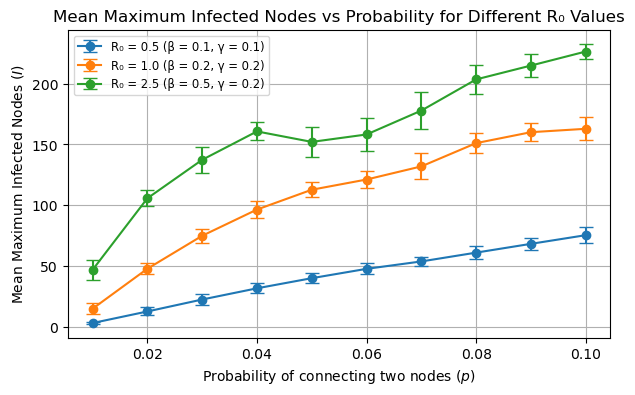

In [71]:
N = 300
p_values = np.linspace(0.01, 0.1, 10)  
R0_values = [0.5, 1.0, 2.5]  
gamma_values = [0.1, 0.2, 0.2]  
I0 = 0.01
t_span = 50
num_runs = 50

er_prob_vs_R0(N, p_values, I0, t_span, num_runs, R0_values, gamma_values)

## 4. Generating Networks and Examining Network Statistics 

The following code generates multiple networks of each type (ER, BA, WS). For each type, we look at the average maximum degree, average minumum degree and average clustering coefficient.

In [72]:
def gen_nets(nettype, N, m_vals, p_vals, p_r_vals, k, num_runs):
    """
    Generate networks of specified types and calculate degree statistics 
    and clustering coefficients.

    Parameters:
        nettype: Network type to generate.
        N: Number of nodes in the network.
        m_vals: List of m values for BA networks.
        p_vals: List of p values for ER networks.
        r_vals: List of r values for WS networks, normally defined as p.
        num_runs: Number of iterations for network generation.
        k: Predifined k for WS networks.

    Returns:
        A dictionary containing minimum and maximum mean and standard 
        deviation values for the degrees and clustering coefficients for 
        each m/p/r value.
    """
    
    mean_min_degrees = []
    std_min_degrees = []
    
    mean_max_degrees = []
    std_max_degrees = []
    
    mean_degrees = []
    std_degrees = []
    
    mean_clustering_coeffs = []  
    std_clustering_coeffs = []    

    if nettype == 'BA':
        for m in m_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                ba_net = nx.barabasi_albert_graph(N, m)
                
                degrees = [deg for _, deg in ba_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(ba_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  

    elif nettype == 'ER':  

        for p in p_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []  

            for _ in range(num_runs):
                er_net = nx.erdos_renyi_graph(N, p)
                
                degrees = [deg for _, deg in er_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(er_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  
    
    elif nettype == 'WS':  

        for p_r in p_r_vals:
            min_degrees = []
            max_degrees = []
            degree_sums = []
            clustering_coeffs = []
            

            for _ in range(num_runs):
                ws_net = nx.watts_strogatz_graph(N, k, p_r)
                
                degrees = [deg for _, deg in ws_net.degree()]

                min_degrees.append(min(degrees))
                max_degrees.append(max(degrees))
                degree_sums.append(np.mean(degrees))  
                clustering_coeffs.append(nx.average_clustering(ws_net))  
                
            mean_min_degrees.append(np.mean(min_degrees))
            std_min_degrees.append(np.std(min_degrees))
            
            mean_max_degrees.append(np.mean(max_degrees))
            std_max_degrees.append(np.std(max_degrees))

            mean_degrees.append(np.mean(degree_sums))
            std_degrees.append(np.std(degree_sums))

            mean_clustering_coeffs.append(np.mean(clustering_coeffs))  
            std_clustering_coeffs.append(np.std(clustering_coeffs))  
            
    return {
        'mean_min_degrees': mean_min_degrees,
        'std_min_degrees': std_min_degrees,
        'mean_max_degrees': mean_max_degrees,
        'std_max_degrees': std_max_degrees,
        'mean_degrees': mean_degrees,
        'std_degrees': std_degrees,
        'mean_clustering_coeffs': mean_clustering_coeffs,  
        'std_clustering_coeffs': std_clustering_coeffs      
    }


def plot_degree_stats(nettype, N, m_vals, p_vals, p_r_vals, k, num_runs):
    """
    Plot degree statistics for generated networks of specified types.

    Parameters:
        nettype: Network type to generate.
        N: Number of nodes in the network.
        m_vals: List of m values for BA networks.
        p_vals: List of p values for ER networks.
        p_r_vals: List of r values for WS networks, defined as p.
        num_runs: Number of iterations for network generation.
        k: Predifined k for WS networks.

    Returns:
        None.
    """

    results = gen_nets(nettype, N, m_vals, p_vals, p_r_vals, k, num_runs)
    
    mean_min_degrees = results['mean_min_degrees']
    std_min_degrees = results['std_min_degrees']
    mean_max_degrees = results['mean_max_degrees']
    std_max_degrees = results['std_max_degrees']
    mean_degrees = results['mean_degrees']
    std_degrees = results['std_degrees']
    
    plt.figure(figsize=(7, 4))

    if nettype == 'BA':
        plt.errorbar(m_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', 
                     capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(m_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', 
                     capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(m_vals, mean_degrees, yerr=std_degrees, fmt='o', 
                     capsize=5, label='Mean Degree', color='red')

        plt.xlabel(r"Number of edges to attach to a new node ($m$)")
        plt.title(
            r"Mean Min, Max, and Overall Degree vs $m$ in Barabási–Albert" 
            " Networks"
            )
        
    elif nettype == 'ER':
        plt.errorbar(p_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', 
                     capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(p_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', 
                     capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(p_vals, mean_degrees, yerr=std_degrees, fmt='o', 
                     capsize=5, label='Mean Degree', color='red')

        plt.xlabel(r"Probability of connecting two edges ($p$)")
        plt.title(
            r"Mean Min, Max, and Overall Degree vs $p$ in Erdös–Renyi" 
            " Networks"
            )

    elif nettype == 'WS':
        plt.errorbar(p_r_vals, mean_min_degrees, yerr=std_min_degrees, fmt='o', 
                     capsize=5, label='Mean Min Degree', color='blue')

        plt.errorbar(r_vals, mean_max_degrees, yerr=std_max_degrees, fmt='o', 
                     capsize=5, label='Mean Max Degree', color='green')

        plt.errorbar(r_vals, mean_degrees, yerr=std_degrees, fmt='o', 
                     capsize=5, label='Mean Degree', color='red')

        plt.xlabel(r"Probability of rewiring an existing edge ($p_r$)")
        plt.title(
            r"Mean Min, Max, and Overall Degree vs $p_r$ in Watts-Strogatz" 
            " Networks"
            )

    plt.ylabel("Degree")
    plt.legend()
    plt.grid(True)
    plt.savefig(nettype + "-degrees.png", dpi=150)
    plt.show()


def plot_clustering_stats(nettype, N, m_vals, p_vals, p_r_vals, k, num_runs):
    """
    Plot clustering coefficient statistics for generated networks of 
    specified types.

    Parameters:
        nettype: Network type to generate.
        N: Number of nodes in the network.
        m_vals: List of m values for BA networks.
        p_vals: List of p values for ER networks.
        r_vals: List of r values for WS networks, normally defined as p.
        num_runs: Number of iterations for network generation.
        k: Predifined k for WS networks.

    Returns:
        None.
    """
    
    results = gen_nets(nettype, N, m_vals, p_vals, p_r_vals, k, num_runs)
    mean_clus_c = results['mean_clustering_coeffs']
    std_clus_c = results['std_clustering_coeffs']

    plt.figure(figsize=(7, 4))

    if nettype == 'BA':
        plt.xlabel(r"Number of edges to attach from a new node ($m$)")
        plt.title(r"Mean Clustering Coefficient vs $m$ in Barabási–Albert" 
                  " Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(m_vals))  
        plt.bar(bar_positions, mean_clus_c, yerr=std_clus_c, width=bar_width, 
                alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, m_vals)  
    
    elif nettype == 'ER':
        plt.xlabel(r"Probability of connecting two edges $p$")
        plt.title(r"Mean Clustering Coefficient vs $p$ in Erdös-Renyi" 
                  r"Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(p_vals))  
        plt.bar(bar_positions, mean_clus_c, yerr=std_clus_c, width=bar_width, 
                alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, np.round(p_vals, 2)) 

    elif nettype == 'WS':
        plt.xlabel(r"Probability of rewiring an existing edge ($p_r$) ")
        plt.title(r"Mean Clustering Coefficient vs $p_r$ in Watts-Strogatz"
                  " Networks")
        bar_width = 0.4  
        bar_positions = np.arange(len(p_r_vals))  
        plt.bar(bar_positions, mean_clus_c, yerr=std_clus_c, width=bar_width, 
                alpha=0.6, color='orange', label='Mean Clustering Coefficient')
        plt.xticks(bar_positions + bar_width / 2, np.round(r_vals, 1)) 


    plt.ylabel("Clustering Coefficient")
    plt.legend()
    plt.grid(True)
    plt.savefig(nettype + "-clustering.png", dpi=150)
    plt.show()

In [73]:
N = 300
m_vals = np.arange(2, 23, 2)
p_vals = np.linspace(0.01, 0.1, 10)
p_r_vals = np.linspace(0.1, 0.9, 10)
k = 8
num_runs = 50

### 4.1 BA Network Results
Below the functions for plotting the degree and clustering statistics of the BA network models are called. Note: Runtime is around 1 minute.

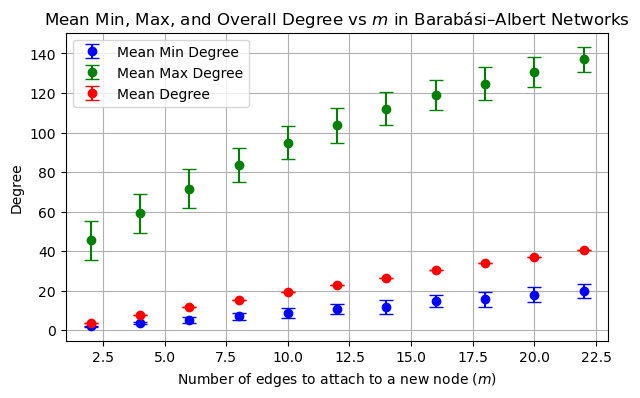

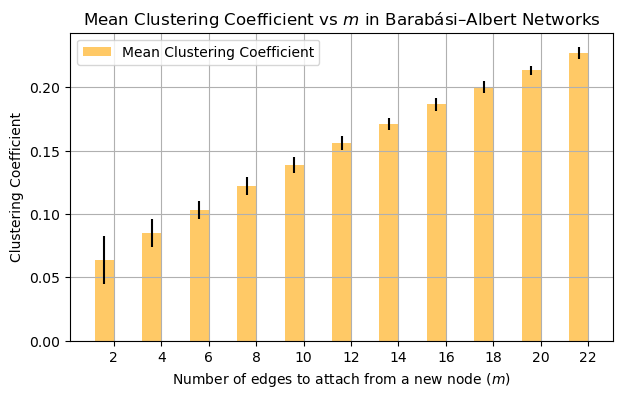

In [74]:
np.random.seed(18)

plot_degree_stats('BA', N, m_vals, p_vals, r_vals, k, num_runs)
plot_clustering_stats('BA', N, m_vals, p_vals, r_vals, k, num_runs)

### 4.2 ER Network Results
Below the functions for plotting the degree and clustering statistics of the ER network models are called.

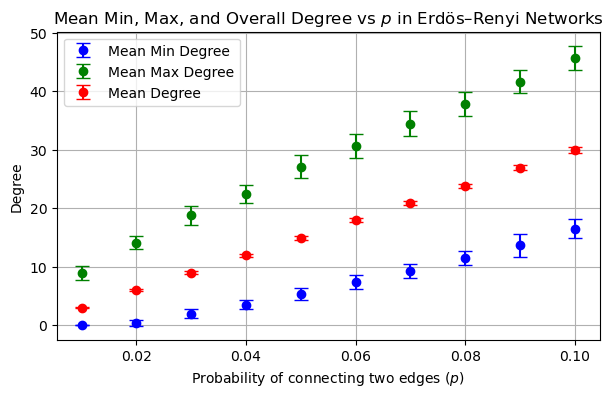

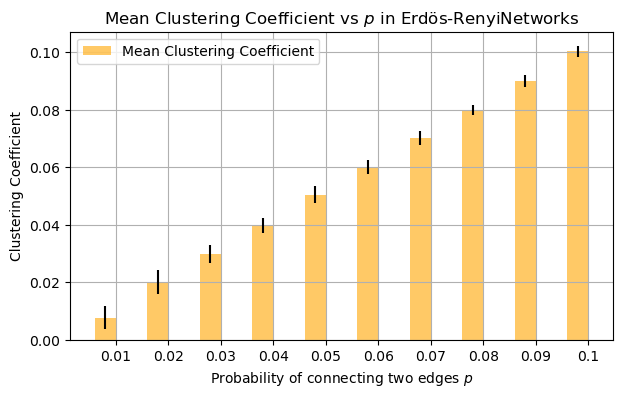

In [75]:
np.random.seed(18)

plot_degree_stats('ER', N, m_vals, p_vals, r_vals, k, num_runs)
plot_clustering_stats('ER', N, m_vals, p_vals, r_vals, k, num_runs)

### 4.3 WS Network Results
Below the functions for plotting the degree and clustering statistics of the WS network models are called.

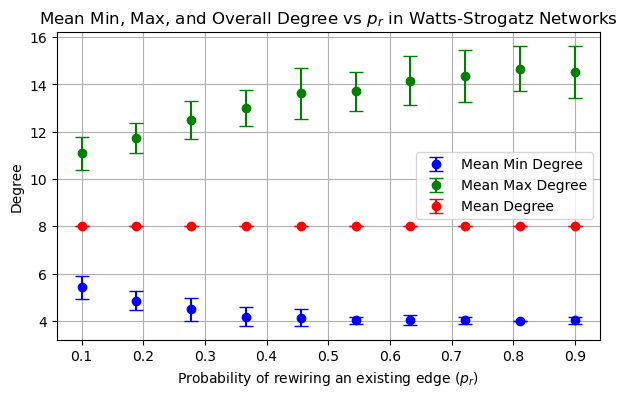

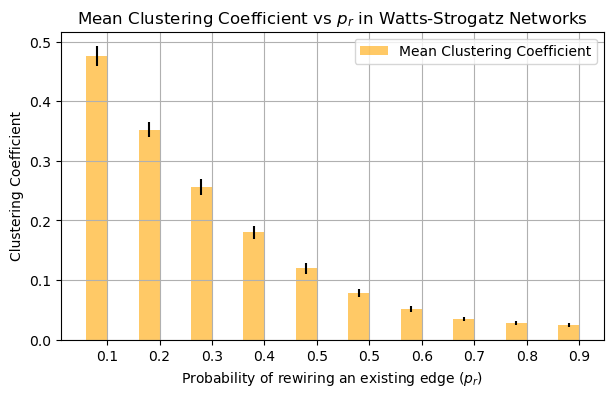

In [76]:
plot_degree_stats('WS', N, m_vals, p_vals, r_vals, k, num_runs)
plot_clustering_stats('WS', N, m_vals, p_vals, r_vals, k, num_runs)

## 5. Dynamic Vaccination Campaign
A network containing predetermined node and edge structure was provided to be modelled in a SIR system and to which a vaccination strategy was to be applied. To ascertain the effectiveness of the strategy, we first designed a random null strategy. The null strategy should then be outperformed by the designed strategy. 

Within each strategy, it is predetermined that we do not know the status of each node until a node is tested. The status a node can have is either 0 (susceptible), 1 (infected) or 2 (removed). Only susceptible nodes can be vaccinated.

Certain limitations are set upon the strategy. There are a limited number of tests (200) and We can only test a specific (although not further specified) number of nodes per iteration of the SIR model. However, tests can have an accuracy rating from 0.25 ton 1.0. An inaccurate test will return a node's status as '1' when it is '0' and vice versa. We assume that recovered nodes always return the correct status. Per iteration, it is also possible to vaccinate a limited amount of susceptible people and their status is changed to removed immediately and indefinitely. 

### 5.1 Loading and Initializing the dataset
First, the provided dataset is loaded correctly and initialised using the corresponding NDLib and NetworkX libraries. Edges between nodes from the dataset were generated per node. Two graphs were generated, one containg the 'true' graph data and one graph signifying the data that we know since we can only assume a node status after testing but we need the actual data for running an accurate simulation. To keep the distinction clear, we generated two graphs. To the known graph, the 'status' opf a node was added to each node such that their data is accesible. All the nodes in the 'known graph' are first set to 0 (susceptible), assuming that every node we have not tested and/or vaccinated yet is susceptible.

In [77]:
def load_sociopatterns():
    """
    Loads and initiates the csv file containing sociopattern information.
    Initiates two graphs, one for actual data and one simulating what we
    know about the data. 
    """

    edge_list = pd.read_csv("transmission_network.csv", delimiter=';', 
                            index_col=0)

    graph = nx.Graph()
    graph_known = nx.Graph()

    graph.add_nodes_from(edge_list.index.tolist())
    graph_known.add_nodes_from(edge_list.index.tolist())

    # Adds edges between nodes if their weight is higher than 0.
    for node_i, row in edge_list.iterrows():
        for node_j, value in row.items():
            if value > 0:
                graph.add_edge(int(node_i), int(node_j))
                graph_known.add_edge(int(node_i), int(node_j))

    return graph, graph_known
    

def initiate_model(graph, graph_known, beta, gamma):
    """" 
    Initiates SIR model on the graph (real world) and sets the status of 
    the known graph to everybody as susceptible.
    """

    model = ep.SIRModel(graph)
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)

    # Initiates states for all nodes in the known graph to susceptible.
    for node in graph_known.nodes:
        graph_known.nodes[node]['status'] = 0

    # Randomly assigns 5 nodes to get infected.
    infected = 5
    infected_nodes = (np.random.choice(graph.nodes(), size=infected, 
                                       replace=False)).tolist()
    config.add_model_initial_configuration('Infected', infected_nodes)
    model.set_initial_status(config)

    return model, graph_known


def update_sir_model(model, graph, iterations):
    """
    Runs the SIR model for a number of times as specified by itertations.
    """
    
    model.iteration_bunch(iterations) 

    return model, graph

### 5.2 Random Null Strategy
To evaluate our vaccination strategy, we had to implement a null strategy to compare our results with. Rather than designing a completely random stratregy, we introduced some intelligence to the strategy to simulate how a random strategy might work in real life rather than something drastically unrealistic.

First nodes are tested by generating a list that contains all known suscpetible nodes. Note from a previous statement that we assume all nodes initially as suscpetible. If there are less susceptible nodes availble then the number of tests to perform, we reset the number of tests.

From the list of available nodes we randomly choose a number of nodes equivalent to the number of tests that we perform that iteration. 

The status of the node is retrieved from the SIRmodel class. A provided list containing the accuracy as [chance correct, chance incorrect] determines the accuracy of the tests. A status tested as '1' may therefore be shown as '0' and vice versa. The status in the known_graph will then be updated to this incorrect result and treat it as correct.  

In [78]:
def test_nodes_random(model, graph_known, tests, vac_pool, accuracy):
    """
    Tests the status of randomly selected susceptible nodes, updates 
    their status accordingly and adds or removes nodes from the 
    vaccination pool.
    
    Arguments:
        model: A class from NDLib to simulate a SIR model.
        graph_known: A graph containing the assumed statuses of nodes.
        tests: Number of maximum tests to do per iteration.
        vac_pool: A list containing nodes ready for vaccination.
        accuracy: A list containing accuracy scores for tests.
        
    Returns
        Updated graph_known, the vaccination pool and number of tests 
        used in this iteration.
    """
    
    available_nodes = [] 

    # Adds people that are susceptible to a list of available nodes.
    for node in graph_known.nodes:
        if graph_known.nodes[node]['status'] == 0:
            available_nodes.append(node)
    
    # Resets the number of tests if there are not enough available nodes.
    if len(available_nodes) < tests:
        tests = len(available_nodes)

        # Returns the function if there are no more available nodes
        if tests == 0:
            return graph_known, vac_pool, tests

    tested_nodes = (np.random.choice(available_nodes, size=tests, 
                                     replace=False)).tolist()

    # Updates the status of the tested nodes on the known graph
    for node in tested_nodes:
        status = model.status[node]

        if status == 0:
            status = np.random.choice([status, 1], p=accuracy)
        elif status == 1:
            status = np.random.choice([status, 0], p=accuracy)
            
        graph_known.nodes[node]['status'] = status

        # Adds to or removes nodes from the vaccination pool.
        if status == 0 and node not in vac_pool:
            vac_pool.append(node)

        elif status != 0 and node in vac_pool:
            vac_pool.remove(node)

    return graph_known, vac_pool, tests

Nodes are vacinated randomly from the vaccination pool as generated during the testing phase. The status of these nodes is then updated accordingly. If the current status of vacccinated node is not o (susceptible), the status is only updated to removed in the known graph. The vaccinated node is removed from the vaccination pool.

In [79]:
def vac_nodes_random(model, graph_known, vac_budget, vac_pool):
    """Vaccinates nodes randomly according to a supplied list of a pool 
    of vaccination candidates. Updates statuses accordingly. If a node 
    status is not actually susceptible, their status is not changed.
    
    Arguments:
        model: A class from NDLib to simulate a SIR model.
        graph_known: A graph containing the assumed statuses of nodes.
        tests: Number of maximum tests to do per iteration.
        vac_pool: A list containing nodes ready for vaccination.
        
    Returns:
        The updated model with correct statuses, graph_known with assumed 
        statuses and vac_pool from which vacinated nodes are removed.
    """

    # If there are not enough Susceptible people, reset the vaccination budget.
    if len(vac_pool) < vac_budget:
        vac_budget = len(vac_pool)

    # Randomly choose susceptible people to vaccinate
    vac_nodes = (np.random.choice(vac_pool, size=vac_budget, 
                                  replace=False)).tolist()

    # Update all statuses of vaccinated nodes to 'Removed' if possible.
    for node in vac_nodes:
        graph_known.nodes[node]['status'] = 2

        if model.status[node] == 0:
            model.status[node] = 2

        # Remove vaccinated from the vaccination pool.
        vac_pool = [node for node in vac_pool if node not in vac_nodes]

    return model, graph_known, vac_pool

The random null strategy campaign first stores initial statuses of nodes in the results. Then, the strategy tests first before vaccinating tested nodes. Afterwards it will iterate over the SIR model to update node statusses accordingly. Results of the current iteration are recorded and saved. This will repeated for a predetermined time span in a while loop until the timespan has passed. 
The campaign is simulated for a specified number of runs (num_runs) to gather a number of maximum values of the infected population per run. A mean and standard deviation will be calculated and returned with the list of maximum values for the number of nodes. 

In [80]:
def random_campaign(test_max, beta, gamma, t_span, accuracy, vac_budget):
    """Runs the random network model null simulation for a number of 
    iterations as specified by t_span and stores data for later 
    visualization. 

    Arguments:
        test_max: MAximum number of tests per iteration.
        beta: Parameter for infection rate.
        gamma: Parameter for recovery rate.
        t_span: Time span to run the simulation.

    Returns:
        The generated results as a dictionary.
    """

    total_tests = 200
    t = 0
    vac_pool = []
    iterations = 1

    results = []

    graph, graph_known = load_sociopatterns()
    model, graph_known = initiate_model(graph, graph_known, beta, gamma)

    infected_count = sum(1 for node in model.status if model.status[node] == 1)
    susceptible_count = sum(1 for node in model.status 
                            if model.status[node] == 0)
    removed_count = sum(1 for node in model.status if model.status[node] == 2)

    results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
            })

    # Tests, vaccinates and riterates the SIR Model.
    while t <= t_span:

        if total_tests > 0:
            graph_known, vac_pool, tests = test_nodes_random(model, graph_known, 
                                                             test_max, vac_pool, 
                                                             accuracy)
            
            # Updates the total number of tests left.
            total_tests -= tests
            
        model, graph_known, vac_pool = vac_nodes_random(model, graph_known, 
                                                        vac_budget, vac_pool)
        update_sir_model(model, graph, iterations)

        # Stores the current states of the model.
        infected_count = sum(1 for node in model.status 
                             if model.status[node] == 1)
        susceptible_count = sum(1 for node in model.status 
                                if model.status[node] == 0)
        removed_count = sum(1 for node in model.status 
                            if model.status[node] == 2)

        t += 1
        
        results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
            })

    return results


def simulate_random_campaign(test_max, beta, gamma, t_span, num_runs, accuracy, 
                             vac_budget):
    """Simulates the random campaign to generate the maximum values for 
    the number of infected and calculates the mean and standard 
    deviations.
    """

    max_I_vals = []

    for _ in range(num_runs):
        results = random_campaign(test_max, beta, gamma, t_span, accuracy, 
                                  vac_budget)
        infected_counts = [entry['infected'] for entry in results]
        max_I = max(infected_counts)
        max_I_vals.append(max_I)
    
    mean_max_I = np.mean(max_I_vals)
    std_max_I = np.std(max_I_vals)

    return max_I_vals, mean_max_I, std_max_I

In [81]:
test_max = 5
beta = 0.05
gamma = 0.01
t_span = 50
num_runs = 5
accuracy = [0.75, 0.25]
vac_budget = 5

simulate_random_campaign(test_max, beta, gamma, t_span, num_runs, accuracy, 
                         vac_budget)

([202, 228, 239, 226, 228], 224.6, 12.191800523302536)

### 5.3 Vaccinating Largest Hubs First Strategy

TODO MARVIN explain

In [82]:
def sort_nodes():
    """
    Initiates graph and sorts nodes based on the amount of neighbors 
    they have.
    """
   
    graph, _ = load_sociopatterns()
    nodes = [(node, graph.degree(node)) for node in graph]
    sorted_nodes = sorted(nodes, key=lambda x: x[1], reverse=True)

    return sorted_nodes
    

def test_hubs(model, graph_known, tests, vac_pool, accuracy):
    """
    Checks available nodes and sorts nodes to test according to their 
    degree scores. Tests the status of the selected top nodes, updates 
    their status accordingly and adds or removes nodes from the 
    vaccination pool.
    
    Arguments:
        model: A class from NDLib to simulate a SIR model.
        graph_known: A graph containing the assumed statuses of nodes.
        tests: Number of maximum tests to do per iteration.
        vac_pool: A list containing nodes ready for vaccination.
        accuracy: A list containing accuracy scores for tests.
        
    Returns
        Updated graph_known, the vaccination pool and number of tests 
        used in this iteration.
    """

    sorted_nodes = sort_nodes()
    available_nodes = []
  
    # Adds people that are susceptible to available nodes
    for node in graph_known.nodes:
        if graph_known.nodes[node]['status'] == 0:
            available_nodes.append(node)
    
    # Resets number of tests if there are not enough available nodes
    if len(available_nodes) < tests:
        tests = len(available_nodes)

        if tests == 0:
            return graph_known, vac_pool, tests
    
    # Selects a limited number of nodes to test if they are available.
    top_nodes = [node for node, _ in sorted_nodes if node in 
                 available_nodes][:tests]
    
    for node in top_nodes:
        status = model.status[node]

        # Returns the correct node status with specified accuracy.
        if status == 0:
            status = np.random.choice([status, 1], p=accuracy)
        elif status == 1:
            status = np.random.choice([status, 0], p=accuracy)
            
        graph_known.nodes[node]['status'] = status

        # Adds to or removes nodes from the vaccination pool.
        if status == 0 and node not in vac_pool:
            vac_pool.append(node)

        elif status != 0 and node in vac_pool:
            vac_pool.remove(node)

    return graph_known, vac_pool, tests


def vac_hubs(model, graph_known, vac_budget, vac_pool):
    """Vaccinates nodes according to a supplied list of a pool 
    of vaccination candidates. Updates statuses accordingly. If a node 
    status is not actually susceptible, their status is not changed.
    
    Arguments:
        model: A class from NDLib to simulate a SIR model.
        graph_known: A graph containing the assumed statuses of nodes.
        tests: Number of maximum tests to do per iteration.
        vac_pool: A list containing nodes ready for vaccination.
        
    Returns:
        The updated model with correct statuses, graph_known with assumed 
        statuses and vac_pool from which vacinated nodes are removed.
    """

    if len(vac_pool) < vac_budget:
        vac_budget = len(vac_pool)

    # Choose largest susceptible hubs.
    vac_nodes = vac_pool[0:vac_budget]

    # Update statuses of vaccinated nodes to 'Removed'.
    for node in vac_nodes:
        graph_known.nodes[node]['status'] = 2

        # Only remove people who are not currently infected or removed.
        if model.status[node] == 0:
            model.status[node] = 2

        # Remove vaccinated nodes from the vaccination pool.
        vac_pool = [node for node in vac_pool if node not in vac_nodes]

    return model, graph_known, vac_pool


def hub_campaign(test_max, beta, gamma, t_span, accuracy, vac_budget):
    """Runs the hub vaccination campaign simulation for a number of 
    iterations as specified by t_span and stores data for later 
    visualization. 

    Arguments:
        test_max: MAximum number of tests per iteration.
        beta: Parameter for infection rate.
        gamma: Parameter for recovery rate.
        t_span: Time span to run the simulation.

    Returns:
        The generated results as a dictionary.
    """

    total_tests = 200
    t = 0
    vac_pool = []
    iterations = 1
    results = []

    # Loads and initializes all data, makes graph of known statuses 
    graph, graph_known = load_sociopatterns()
    model, graph_known = initiate_model(graph, graph_known, beta, gamma)

    """    # Store the current state of the model.
    infected_count = sum(1 for node in model.status 
                         if model.status[node] == 1)
    susceptible_count = sum(1 for node in model.status 
                            if model.status[node] == 0)
    removed_count = sum(1 for node in model.status 
                        if model.status[node] == 2)

    results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
        })"""

    # Tests, vaccinates and simulates SIR for a set number of iterations.
    while t <= t_span:
        if total_tests > 0:
            graph_known, vac_pool, tests = test_hubs(model, graph_known, 
                                                     test_max, vac_pool, 
                                                     accuracy)
            total_tests -= tests
            
        model, graph_known, vac_pool = vac_hubs(model, graph_known, 
                                                vac_budget, vac_pool)
        
        update_sir_model(model, graph, iterations)

        infected_count = sum(1 for node in model.status 
                             if model.status[node] == 1)
        susceptible_count = sum(1 for node in model.status 
                                if model.status[node] == 0)
        removed_count = sum(1 for node in model.status 
                            if model.status[node] == 2)

        t += 1

        results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
        })

    return results


def simulate_hub_campaign(test_max, beta, gamma, t_span, num_runs, accuracy, 
                          vac_budget):
    """Simulates the hub campaign to generate the maximum values for 
    the number of infected and calculates the mean and standard 
    deviations.
    """

    max_I_vals = []

    for _ in range(num_runs):
        results = hub_campaign(test_max, beta, gamma, t_span, accuracy, 
                               vac_budget)
        infected_counts = [entry['infected'] for entry in results]
        max_I = max(infected_counts)
        max_I_vals.append(max_I)
    
    mean_max_I = np.mean(max_I_vals)
    std_max_I = np.std(max_I_vals)

    return max_I_vals, mean_max_I, std_max_I

### 5.4 Highest Score First Strategy
As we saw a general improvement where the total number of infected individuals is, on average, lower than the null campaign. We wanted to find the significance of adding more score baseed assesments to a vaccination strategy. We chose to assess the Closeness, betweenness and adjecency. 

Adjacency measures the number of edges that a node has. Nodes with high adjacency connect to many neighbors.

Closeness indicates how quickly a node can reach others in the network. High closeness indicates that nodes have a short average path length to other nodes.

Betweenness indicates how often a node lies on the shortest path between other nodes. Nodes with high betweenness serve as bridges.

Scores for each are calculated seperately and the scopres are sorted from highest to lowest. Scores are then scaled to the highest value such that theirt values range from 1 to 0. Finally, all scores are added per node and the scores are resorted with the scores lying between 3 and the 0.

In [83]:
def calc_closeness(graph):
    """Calculates the closeness of each node and returns a sorted 
    list with scaled scores.
    """

    closeness = nx.closeness_centrality(graph)
    sort_clo = sorted(closeness.items(), key=lambda x: x[1], reverse=True)
    clo_scores = assign_scores(sort_clo)

    return clo_scores


def calc_betweenness(graph):
    """Calculates the betweenness of each node and returns a sorted 
    list with scaled scores.
    """

    betweenness = nx.betweenness_centrality(graph)
    sort_bet = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    bet_scores = assign_scores(sort_bet)

    return bet_scores


def calc_adjecency(graph):
    """Calculates the adjecency of each node and returns a sorted 
    list with scaled scores.
    """

    adjecency = dict(graph.degree())
    sort_adj = sorted(adjecency.items(), key=lambda x: x[1], reverse=True)
    adj_scores = assign_scores(sort_adj)
    
    return adj_scores


def assign_scores(sortedlist):
    """Scales the scores of a given list such that they rank from 
    0 to 1.
    """

    value_max = sortedlist[0][1]
    score_dict = {}

    for node, score in sortedlist:
        score_dict[node] = np.round((score/value_max), 4)
    
    return score_dict


def calc_total_scores(graph):
    """Calculates the total scores of each node and sorts the scores 
    from highest to lowest.
    """

    score_adj = calc_adjecency(graph)
    score_bet = calc_betweenness(graph)
    score_clo = calc_closeness(graph)
    score_total = {}
    
    for node in score_adj:
        score_total[node] = np.round(score_adj[node] + score_bet.get(node, 0) 
                                     + score_clo.get(node, 0), 4)

    sorted_scores = dict(sorted(score_total.items(), key=lambda x: x[1], 
                                reverse=True))
     
    return sorted_scores

Nodes are not immediately tested based on scores but rather checked if they are neighboring a previouslt determined infected node. Neighbors of a previously infected node will receive a a higher score based on the score of the infected node they neighbor. This may result in nodes being higher in the score list but does not neccesarily prioritize them over all the nodes. 

A list of nodes neighboring infected noides is made and those nodes are assigned a higher score. This will only occu once per infected neighbor in the total simulation by checking if they did not already receive a score boost. This is checked by storing infected nodes in 'infected' until they have assigned scores to neighbors. Tests are, however, susceptible to accuracy errors and will return either a false susceptible for an infected node or a false infected for a susceptible node.

All (known) susceptible nodes are then added to the test candidate list and sorted. The top nodes, dependent on the number of tests, are teste and their status is set to the tested status in the known graph. Remember that the true status of a node is not always up to dat and also susceptible to accuracy errors in the test phase. 

Susceptible nodes are added to the vaccination pool and all other statusses are removed from the vaccination pool. 

In [84]:
def test_nodes_score(tests, scores, graph_known, model, vac_pool, infected, 
                     accuracy):
    """
    Tests nodes to determine their infection status based on scores 
    and known statuses. Only tests nodes that are not currently removed 
    or infected.

    Parameters:
        tests: Maximum number of nodes to test.
        scores: Dictionary of nodes with their associated scores.
        graph_known: The graph representing known node statuses.
        model: The model containing the current status of each node.
        vac_pool: List of nodes available for vaccination.
        infected: List of currently infected nodes.
        accuracy: Probabilities for testing accuracy (true positive, 
                  false positive).

    Returns:
        Updated values for the graph_known, vaccination pool and list of 
        infected nodes.
    """

    test_nodes = []
    tested_nodes = []

    for node, _ in scores.items():
        # find neighbors of known infected add to list
        if graph_known.nodes[node]['status'] == 1:
            neighbors_list = [n for n in graph_known.neighbors(node) 
                              if graph_known.nodes[n]['status'] == 0]
            
            for n in neighbors_list:
                if n not in test_nodes:
                    test_nodes.append(n)
                
                if node in infected:
                    scores[n] += scores[node]

            if node in infected: 
                infected.remove(node)

        # Add susceptible known to list
        elif graph_known.nodes[node]['status'] == 0:
            test_nodes.append(node)

    # Sorts the nodes to test based on their score
    test_nodes = sorted(test_nodes, key=lambda x: scores.get(x, 0), 
                        reverse=True)

    for node in test_nodes[:tests]:
        status = model.status[node]

        # Status may change according to the test accuracy 
        if status == 0:
            status = np.random.choice([status, 1], p=accuracy)
        elif status == 1:
            status = np.random.choice([status, 0], p=accuracy)
            
        graph_known.nodes[node]['status'] = status
        tested_nodes.append(node)

        # Add or remove nodes to their corresponding list
        if status == 0 and node not in vac_pool:
            vac_pool.append(node)
        elif status == 1 and node in vac_pool:
            vac_pool.remove(node)
            infected.append(node)
        elif status == 2 and node in vac_pool:
            vac_pool.remove(node)
    
    #sort the vac_pool based on their score 
    vac_pool = sorted(vac_pool, key=lambda x: scores.get(x, 0), reverse=True)

    return graph_known, vac_pool, infected


Nodes are vaccinated dependent on the vaccination budget and available nodes in the vaccination pool. The top nodes, dependent on the number of vaccinations, are vaccinated and their status is set to 'removed'' in the known graph. The status is only updated in the model if their true status was susceptible. Remember that the true status of a node is not always up to date and may experience accuracy errors in the test phase. 

In [85]:
def vac_nodes_score(model, graph_known, vac_budget, vac_pool, scores):
    """
    Tests nodes for infection based on their score and updates their 
    status, prioritizing nodes based on score.

    Parameters:
        tests: Maximum number of nodes to test.
        scores: Node scores indicating infection likelihood.
        graph_known: Graph with each node's known status.
        model: Model with 'status' attribute for current node statuses.
        vac_pool: List nodes selected for vaccination.
        infected: List of infected nodes.
        accuracy: Probability of correct test results for each status.

    Returns:
        Updated data for graph_known, vac_pool, tested_nodes and 
        infected.
    """

    if len(vac_pool) < vac_budget:
        add_to_pool = vac_budget - len(vac_pool)
        candidates = [node for node in graph_known.nodes 
                      if graph_known.nodes[node]['status'] == 0 
                      and node not in vac_pool]
        sorted_c = sorted(candidates, key=lambda x: scores.get(x, 0), 
                          reverse=True)

        for c in sorted_c[:add_to_pool]:
            vac_pool.append(c)

        vac_budget = len(vac_pool)

    vac_nodes = vac_pool[0:vac_budget]

    # Update all statuses of vaccinated nodes to 'Removed'
    for node in vac_nodes:
        graph_known.nodes[node]['status'] = 2

        # Can only remove people who are not currently infected or removed
        if model.status[node] == 0:
            model.status[node] = 2

        # Remove vaccinated from vaccination pool
        vac_pool.remove(node)

    return model, graph_known, vac_pool

The final simulation is run for a predetermined time span and a specified number of times and tests are only carried out while there are tests remaining in the total test buidget. The results are stored to be analyzed later. The means and standard deviations of the maximum number of infected in each run is also calculated and stored.

In [86]:
def score_campaign(test_max, beta, gamma, t_span, accuracy, vac_budget):
    """
    Simulates an SIR model score based vaccination campaign.

    Arguments:
        test_max: Maximum number of nodes to test per time step.
        beta: Infection rate.
        gamma: Recovery rate.
        t_span: Total time duration for the simulation.

    Returns:
        A list of dictionaries containing infection counts, 
        susceptible counts, removed counts, vaccination pool size, and 
        remaining tests at each time step.
    """

    total_tests = 200
    t = 0
    vac_pool = []
    iterations = 1
    infected = []
    results = []

    # Loads and initializes all data, makes a graph of the known statuses.
    graph, graph_known = load_sociopatterns()
    model, graph_known = initiate_model(graph, graph_known, beta, gamma)

    # Assign scores to nodes based on adjecency, betweenness and closeness.
    scores_dict = calc_total_scores(graph)

    while t <= t_span:
        if total_tests > 0:
            graph_known, vac_pool, infected = test_nodes_score(test_max, 
                                        scores_dict, graph_known, 
                                        model, vac_pool, infected, accuracy)
            
        model, graph_known, vac_pool = vac_nodes_score(model, graph_known, 
                                        vac_budget, vac_pool, scores_dict)
        
        update_sir_model(model, graph, iterations)

        total_tests -= test_max

        # Reset tests per iteration if the budget is too small.
        if total_tests < test_max:
            test_max = total_tests

        # Store the current state of the model
        infected_count = sum(1 for node in model.status 
                             if model.status[node] == 1)
        susceptible_count = sum(1 for node in model.status 
                                if model.status[node] == 0)
        removed_count = sum(1 for node in model.status 
                            if model.status[node] == 2)

        # Append results for the current time step
        results.append({
            'time': t,
            'infected': infected_count,
            'susceptible': susceptible_count,
            'removed': removed_count,
            'vaccination_pool_size': len(vac_pool),
            'total_tests_remaining': total_tests,
        })

        t += 1

    return results


def simulate_score_campaign(test_max, beta, gamma, t_span, num_runs, accuracy, 
                            vac_budget):
    """
    Runs multiple simulations of the score-based campaign.

    Parameters:
        test_max: Maximum number of tests per time step.
        beta: Infection rate.
        gamma: Recovery rate.
        t_span: Total time duration for each simulation run.
        num_runs: Number of times to repeat the simulation.

    Returns:
        A List of peak infection counts across runs, the average of peak 
        infection counts and the standard deviation of peak infection 
        counts.
    """

    max_I_vals = []

    for _ in range(num_runs):
        results = score_campaign(test_max, beta, gamma, t_span, accuracy, 
                                 vac_budget)
        infected_counts = [entry['infected'] for entry in results]
        max_I = max(infected_counts)
        max_I_vals.append(max_I)
    
    mean_max_I = np.mean(max_I_vals)
    std_max_I = np.std(max_I_vals)

    return max_I_vals, mean_max_I, std_max_I

In [87]:
test_max = 10
beta = 0.05
gamma = 0.01
t_span = 50
num_runs = 5

simulate_score_campaign(test_max, beta, gamma, t_span, num_runs, accuracy, 
                        vac_budget)

([125, 89, 100, 91, 169], 114.8, 29.975990392312312)

### 5.5 Choosing a Campaign Strategy

To compare the strategies, data from all campaigns is gathered to be plotted against each other. 

The highest Infected values for each campaign are gathered multiple times for which the mean ius calculated, as well as the standard deviation. These are then plotteds with eror bars to compare the vaccination strategies.

A plot of the mean development of the S, I and R populations over time for each vaccination strategy is also plotted.

In [88]:
def show_campaign_results(test_max, beta, gamma, t_span, num_runs, accuracy, 
                          vac_budget):
    """
    Plots the mean maximum infected counts for random, hub and score
    campaigns with their standard deviations.
    """
    
    _, mean_max_random, std_max_random = simulate_random_campaign(
        test_max, beta, gamma, t_span, num_runs, accuracy, vac_budget)
    
    _, mean_max_hub, std_max_hub = simulate_hub_campaign(
        test_max, beta, gamma, t_span, num_runs, accuracy, vac_budget)
    
    _, mean_max_score, std_max_score = simulate_score_campaign(
        test_max, beta, gamma, t_span, num_runs, accuracy, vac_budget)

    x_labels = ['Random', 'Hub', 'Score']  
    means = [mean_max_random, mean_max_hub, mean_max_score]  
    std_devs = [std_max_random, std_max_hub, std_max_score]  

    plt.figure(figsize=(7, 4))
    plt.errorbar(x=np.arange(len(means)), y=means, yerr=std_devs, fmt='o', 
                 capsize=5, color='blue', alpha=0.7, 
                 label='Mean Max Infected Counts')

    plt.xticks(np.arange(len(x_labels)), x_labels)
    plt.title('Mean Maximum Infected Counts with Standard Deviation')
    plt.ylabel('Count of Infected Individuals')
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.savefig("vacc-means.png", dpi=150)
    plt.show()


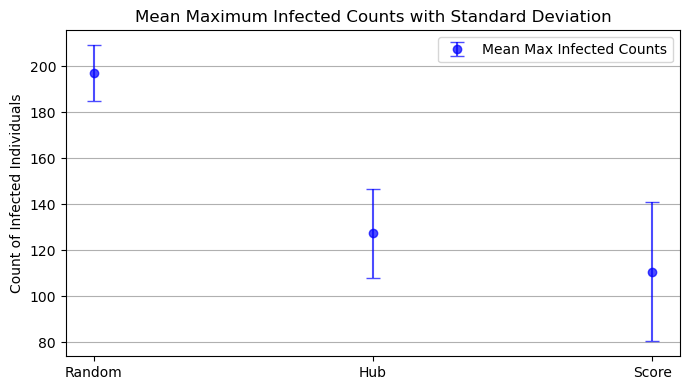

In [89]:
test_max = 10
beta = 0.05
gamma = 0.01
t_span = 50
num_runs = 20

show_campaign_results(test_max, beta, gamma, t_span, num_runs, accuracy, 
                      vac_budget)

To compare the campaigns, we also plotted the data of each population against time to see a trend. 

In [90]:
def calc_mean_strategies(test_max, beta, gamma, t_span, num_runs, accuracy, 
                         vac_budget):
    """Calculates the mean values for the populations for each 
    strategy.
    """
        
    num_time_steps = t_span 
    num_runs = num_runs 

    i_mean_r = [[] for _ in range(num_time_steps)]
    s_mean_r = [[] for _ in range(num_time_steps)]
    r_mean_r = [[] for _ in range(num_time_steps)]

    i_mean_h = [[] for _ in range(num_time_steps)]
    s_mean_h = [[] for _ in range(num_time_steps)]
    r_mean_h = [[] for _ in range(num_time_steps)]

    i_mean_s = [[] for _ in range(num_time_steps)]
    s_mean_s = [[] for _ in range(num_time_steps)]
    r_mean_s = [[] for _ in range(num_time_steps)]

    for _ in range(num_runs):
        
        results_r = random_campaign(test_max, beta, gamma, t_span, accuracy, 
                                    vac_budget)
        infected_r = [entry['infected'] for entry in results_r]
        susceptible_r = [entry['susceptible'] for entry in results_r]
        removed_r = [entry['removed'] for entry in results_r]

        results_h = hub_campaign(test_max, beta, gamma, t_span, accuracy, 
                                 vac_budget)
        infected_h = [entry['infected'] for entry in results_h]
        susceptible_h = [entry['susceptible'] for entry in results_h]
        removed_h = [entry['removed'] for entry in results_h]

        results_s = score_campaign(test_max, beta, gamma, t_span, accuracy, 
                                   vac_budget)
        infected_s = [entry['infected'] for entry in results_s]
        susceptible_s = [entry['susceptible'] for entry in results_s]
        removed_s = [entry['removed'] for entry in results_s]

        for time_step in range(num_time_steps):
            i_mean_r[time_step].append(infected_r[time_step])
            s_mean_r[time_step].append(susceptible_r[time_step])
            r_mean_r[time_step].append(removed_r[time_step])

            i_mean_s[time_step].append(infected_s[time_step])
            s_mean_s[time_step].append(susceptible_s[time_step])
            r_mean_s[time_step].append(removed_s[time_step])

            i_mean_h[time_step].append(infected_h[time_step])
            s_mean_h[time_step].append(susceptible_h[time_step])
            r_mean_h[time_step].append(removed_h[time_step])


    mean_i_r = [np.mean(i_mean_r[time_step]) for time_step 
                in range(num_time_steps)]
    mean_s_r = [np.mean(s_mean_r[time_step]) for time_step 
                in range(num_time_steps)]
    mean_r_r = [np.mean(r_mean_r[time_step]) for time_step 
                in range(num_time_steps)]

    mean_i_s = [np.mean(i_mean_s[time_step]) for time_step 
                in range(num_time_steps)]
    mean_s_s = [np.mean(s_mean_s[time_step]) for time_step 
                in range(num_time_steps)]
    mean_r_s = [np.mean(r_mean_s[time_step]) for time_step 
                in range(num_time_steps)]

    mean_i_h = [np.mean(i_mean_h[time_step]) for time_step 
                in range(num_time_steps)]
    mean_s_h = [np.mean(s_mean_h[time_step]) for time_step 
                in range(num_time_steps)]
    mean_r_h = [np.mean(r_mean_h[time_step]) for time_step 
                in range(num_time_steps)]

    mean_r = [mean_s_r, mean_i_r, mean_r_r]
    mean_h = [mean_s_h, mean_i_h, mean_r_h]
    mean_s = [mean_s_s, mean_i_s, mean_r_s]

    return mean_r, mean_h, mean_s
    

def plot_strategies_sir(mean_r, mean_h, mean_s, t_span):
    """Plots the results of the SIR vaccination campaign simulations.

    Arguments:
        mean_r: Calculated mean values for the random campaign.
        mean_h: Calculated mean values for the hub campaign.
        mean_s: Calculated mean values for the score campaign.
        t_span: timespan of each run.

    Returns:
        None, plots a graph.
    """

    mean_s_r, mean_i_r, mean_r_r = mean_r
    mean_s_h, mean_i_h, mean_r_h = mean_h
    mean_s_s, mean_i_s, mean_r_s = mean_s

    time = np.arange(0, t_span, 1)

    plt.figure(figsize=(10, 6))
    plt.plot(time, mean_s_r, label='Random (S)', color='b', linestyle='-')
    plt.plot(time, mean_i_r, label='Random (I)', color='orange', linestyle='-')
    plt.plot(time, mean_r_r, label='Random (R)', color='g', linestyle='-')

    plt.plot(time, mean_s_h, label='Hub (S)', color='b', linestyle='--')
    plt.plot(time, mean_i_h, label='Hub (I)', color='orange', linestyle='--')
    plt.plot(time, mean_r_h, label='Hub (R)', color='g', linestyle='--')

    plt.plot(time, mean_s_s, label='Score (S)', color='b', linestyle=':')
    plt.plot(time, mean_i_s, label='Score (I)', color='orange', linestyle=':')
    plt.plot(time, mean_r_s, label='Score (R)', color='g', linestyle=':')
    
    plt.xlabel('Time (days)')
    plt.ylabel('Population (N)')
    plt.title('SIR Model Vaccination Campaigns')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("vacc-development.png", dpi=150)
    plt.show()


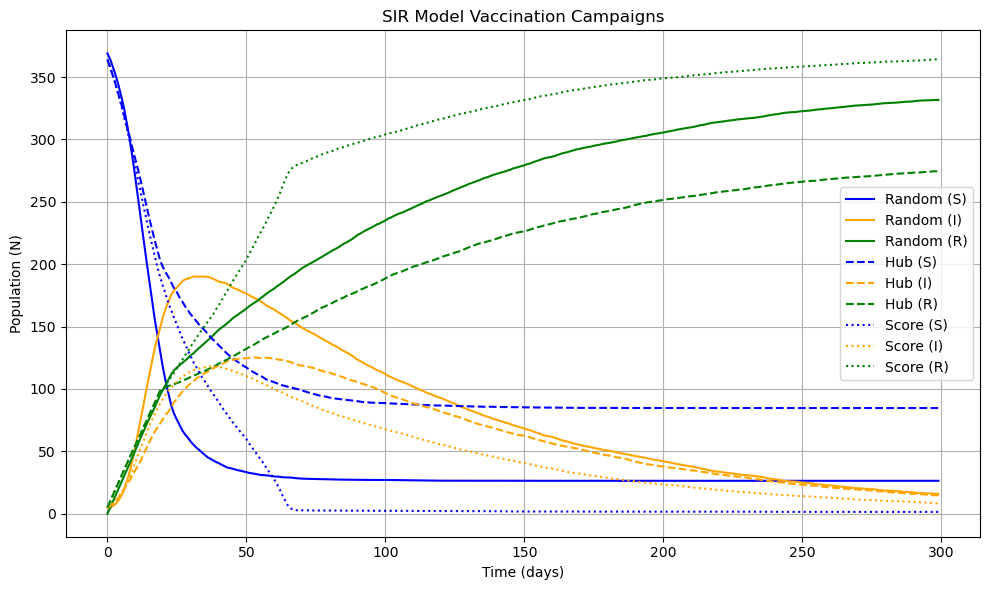

In [91]:
test_max = 10
beta = 0.05
gamma = 0.01
t_span = 300
num_runs = 30
accuracy = [0.75, 0.25]

mean_r, mean_h, mean_s = calc_mean_strategies(test_max, beta, gamma, t_span, 
                                              num_runs, accuracy, vac_budget)
plot_strategies_sir(mean_r, mean_h, mean_s, t_span)

### 5.6 Comparing Null and Hub Strategies for Different Accuracies and Vaccination Budgets

To compare the null and hub strategy we compared them based on different accuracy scores and vaccination budgets. For each strategy we plotted the mean outcome for the infection peak and the standard deviations. To keep the plots concise and readable, we varried the vaccination budget per accuracy score. 

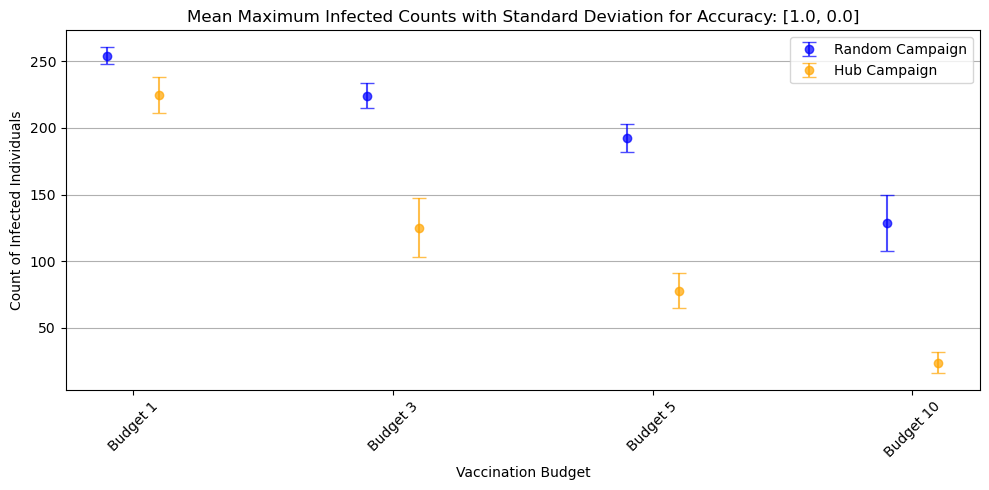

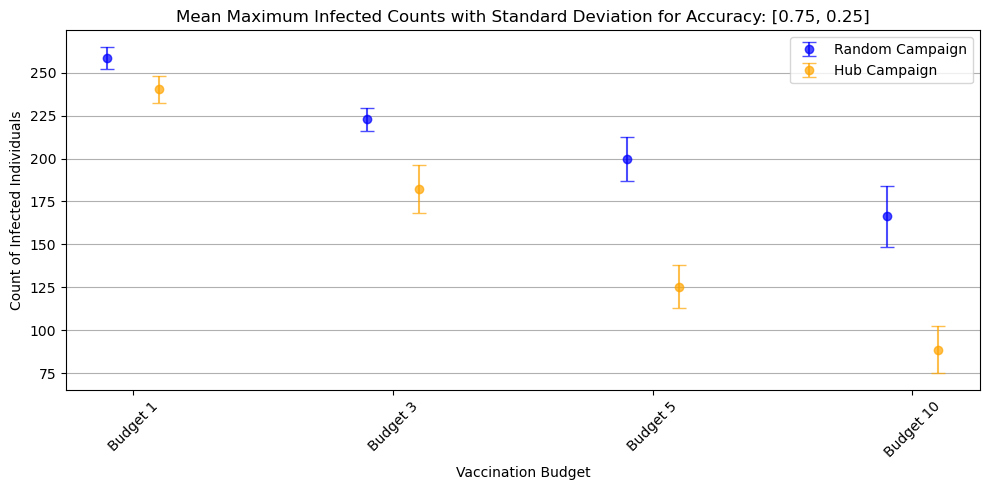

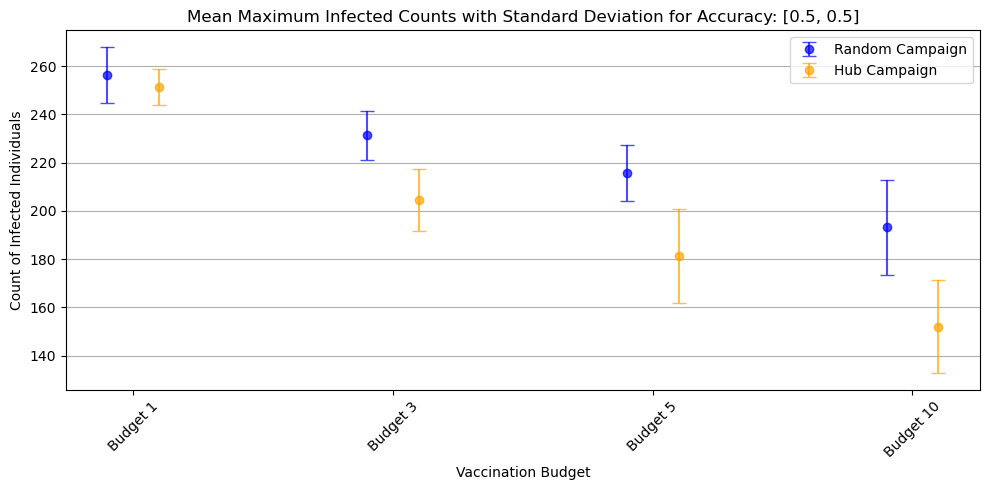

In [92]:
def show_all_campaign_results(test_max, beta, gamma, t_span, num_runs, 
                              accuracy, vac_budget_list):
    """
    Plots the mean maximum infected counts for random and hub campaigns 
    with their standard deviations.
    """
    
    means_random = []
    std_devs_random = []
    means_hub = []
    std_devs_hub = []
    x_labels = []

    for vac_budget in vac_budget_list:
        # Simulate the random campaign.
        _, mean_max_random, std_max_random = simulate_random_campaign(
            test_max, beta, gamma, t_span, num_runs, accuracy, vac_budget)
        means_random.append(mean_max_random)
        std_devs_random.append(std_max_random)

        # Simulate the hub campaign.
        _, mean_max_hub, std_max_hub = simulate_hub_campaign(
            test_max, beta, gamma, t_span, num_runs, accuracy, vac_budget)
        means_hub.append(mean_max_hub)
        std_devs_hub.append(std_max_hub)

        x_labels.append(f'Budget {vac_budget}')

    plt.figure(figsize=(10, 5))

    # Create the x positions for the bars
    x_positions_random = np.arange(len(vac_budget_list)) 
    x_positions_hub = x_positions_random + 0.2 

    # Plot the random campaign results.
    plt.errorbar(x=x_positions_random, y=means_random, yerr=std_devs_random, 
                 fmt='o', capsize=5, color='blue', alpha=0.7, 
                 label='Random Campaign')

    # Plot the hub campaign results.
    plt.errorbar(x=x_positions_hub, y=means_hub, yerr=std_devs_hub, fmt='o', 
                 capsize=5, color='orange', alpha=0.7, label='Hub Campaign')

    plt.xticks(x_positions_random + 0.1, x_labels, rotation=45)

    plt.title(f"Mean Maximum Infected Counts with Standard Deviation for "
              f"Accuracy: {accuracy}")
    
    plt.ylabel('Count of Infected Individuals')
    plt.xlabel('Vaccination Budget')
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.savefig("vacc-means.png", dpi=150)
    plt.show()


test_max = 10
beta = 0.05
gamma = 0.01
t_span = 50
num_runs = 10
vac_budget_list = [1, 3, 5, 10]

# Simulate for different accuracy levels
for accuracy in [[1.0, 0.0], [0.75, 0.25], [0.5, 0.5]]:
    show_all_campaign_results(test_max, beta, gamma, t_span, num_runs, 
                              accuracy, vac_budget_list)
